# 1. Konfiguracja środowiska
Aby przygotowany Notebook działał poprawnie trzeba wskazać katalogi, w których znajdują się dane.


*   __`reflex_project_path`__ - katalog głowny repozytorium, w którym umieszone są wszystkie wymagane biblioteki
*   __`raw_data_files`__ - folder, w którym przechowywane są dane jako surowe tablice `.npy.bz2`
* __`results_dir`__ - folder wynikowy, do którego zapiszemy wszystkie wygenerowane wyniki
* __`default_branch`__ - branch, z którego korzystamy.
* __`overwrite_files`__ - wartość w przypadku przeprowadzania eksprymentu wszystkie pliki zostają nadpisne nowymi (#TODO)
* __`experiment_name`__ - nazwa eksperymentu, ktory zostanie zapisany pod taka nazwe w folderze data.


In [0]:
#@title Konfiguracja zmiennych:

import sys
reflex_project_path = "/home/reflex/reflex" #@param {type:"string"}
default_branch = "master" #@param {type:"string"}
raw_data_files = "/mnt/disks/raw/all" #@param {type:"string"}
results_dir = "/home/reflex/reflex/data/results" #@param {type:"string"}
overwrite_files = True #@param ["True", "False"] {type:"raw"}
experiment_name = "labeler_768" #@param {type:"string"}

results_dir += f'_{experiment_name}' 
sys.path.append(reflex_project_path)

# 2. Aktualizacja lokalnego repozytorium
Zakładam, że repozytorium zostało już założone na maszynie wirtualnej.

In [34]:
!cd '{reflex_project_path}' && pwd && git checkout '{default_branch}' && git pull origin '{default_branch}'

/home/reflex/reflex
M	modules/radial_compressor.py
Already on 'master'
Your branch is up to date with 'origin/master'.
From gitlab.cs.put.poznan.pl:dbrzezinski/refleX
 * branch            master     -> FETCH_HEAD
Already up to date.


# 3. Instalowanie zależności
W przypadku uruchamiania skryptu na maszynach wirtualnych warto upewnić się, że wszystkie zależności zostały spełnine. Może być przydatne w procesie przenoszenia kodu na inne maszyny i może skrócić czas debugowania.

In [0]:
#!python3 -m pip install -r '{reflex_project_path}/requirements.txt'
#!conda install --file '{reflex_project_path}/requirements.txt'

# 3. Pełny preprocessing

## 3.1 Importowanie modułów


In [0]:
%load_ext autoreload
%autoreload 2

#Obsluga plikow .npy.bz2
from modules.rawdatalib import RawDataFile

# Wyznaczanie srodka oraz kata, pod ktorym pada promien
from modules.preprocessinglib import calculate_center, find_ray_angle

# Kompresja obrazu do wektora 1D
from modules.radial_compressor import main_external_call, make_ray_mask

# Funkcje pomocnicze
import modules.util as util

# Pozostale
import os
import cv2 as cv
import time
import bz2
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from multiprocessing import Pool, Lock

## 3.2 Tworzenie struktury katalogów

In [0]:
# Tworzenie folderu wynikowego
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
  
# Tworzenie zmiennych pomocniczych
csv_dir = f'{results_dir}/csv'
images_dir = f'{results_dir}/images'
vectors_dir = f'{results_dir}/vectors'
normalized_npy_arrays_dir = f'{results_dir}/vectors'

# Tworzenie katalogow posrednich, w ktorych bedziemy trzymac dane
abs_dirs = [csv_dir, images_dir, vectors_dir, normalized_npy_arrays_dir]
  
# Tworzenie folderow posrednich
for dir in abs_dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)

## 3.3 Etap I. - Wczytywanie, normalizowanie i zapisywanie jako obraz surowych danych.

In [4]:
def npy_to_img(idx, raw_file_path):
    
    # Okreslamy rozmiar obrazu, ktory ma zostac wygenerowany
    img_size = 768
  
    # Dla kazdego pliku generowany jest jego obiekt, ktory normalizuje obraz
    # oraz moze wyodrebniac informacje z metadanych (w przyszlosci mozemy
    # pozyskiwac srodek obrazu z zalaczonych do niego informacji w pliku .info)
    raw_file = RawDataFile(raw_file_path)
    image = raw_file.to_img(size=img_size)
    
    if 'beam_x' in raw_file.info.keys() and 'beam_y' in raw_file.info.keys() and 'distance' in raw_file.info.keys() and 'wavelength' in raw_file.info.keys():
      with lock:
        # WALIDOWAC CZY WPIS NIE ISTNIEJE!
        # TWORZYC PUSTY PLIK CSV ?
        util.write_to_csv(f'{csv_dir}/metadata_centers.csv', 
        {
           'image' : raw_file.filename,
           'x' : raw_file.info['beam_x'], 
           'y' : raw_file.info['beam_y'],
           'distance' : raw_file.info['distance'],
           'wavelength' : raw_file.info['wavelength']
        })
      
    cv.imwrite(f'{images_dir}/{raw_file.filename}.png', image)
    
    # Informacja
    print(f"Przetworzono: {raw_file.filename} | ({idx + 1}/{total})")
    
    #Nie img -> .npy

if os.path.exists(raw_data_files):
  
  # Pobranie listy plikow z folderu
  raw_files = [f'{raw_data_files}/{file}' for file in os.listdir(raw_data_files) if file.endswith('.npy.bz2')]
  
  # Liczba wszystkich plikow
  total = len(raw_files)
  
  # Rozpoczynami pomiar czasu
  start = time.time()

  # Lock
  lock = Lock()
    
  Parallel(n_jobs=8)(delayed(npy_to_img)(idx, raw_file_path) 
                     for idx, raw_file_path in enumerate(raw_files))    
    
  # Konczymy pomiar czasu
  end = time.time()
  time_str = time.strftime("%H:%M:%S", time.gmtime(end - start))
  
  print(f"\n --- KONIEC --- \n Przetworzono: {total} plikow, czas przetwarzania: {time_str}s")
  
else:
  raise FileNotFoundError("Katalog z plikami RAW nie istnieje!")

Przetworzono: 201817_1_00001 | (7/6129)
Przetworzono: khc3_4_1_001 | (8/6129)
Przetworzono: prv7-6 | (2/6129)
Przetworzono: idp05232b | (4/6129)
Przetworzono: 217343a5_cx#### | (12/6129)
Przetworzono: 90419_3_001 | (6/6129)
Przetworzono: 58118_1 | (3/6129)
Przetworzono: 46904_2_001 | (1/6129)
Przetworzono: 88089_1_E2_001 | (5/6129)
Przetworzono: 248067c1_x0001 | (16/6129)
Przetworzono: quk9-3_5_00001 | (11/6129)
Przetworzono: 30723_1_E1 | (9/6129)
Przetworzono: IDP91967-3b | (10/6129)
Przetworzono: xtal4-peg2-4c-x1.0001 | (14/6129)
Przetworzono: ny-znac-m3g6-2.0001 | (17/6129)
Przetworzono: 70568_1_E1_1000 | (13/6129)
Przetworzono: 40976_1_E2_001 | (22/6129)
Przetworzono: 96990_1_E1 | (15/6129)
Przetworzono: IDP02237-3b | (19/6129)
Przetworzono: 57037_1_E1_001 | (20/6129)
Przetworzono: 108276_1_001 | (18/6129)
Przetworzono: 229338F10_x0001 | (29/6129)
Przetworzono: 15521_2_001 | (25/6129)
Przetworzono: idp01616d | (21/6129)
Przetworzono: 48960_2_001 | (23/6129)
Przetworzono: 46035_1_E1

Przetworzono: idp02160bh | (65/6129)
Przetworzono: 156851_1_E2_0001 | (69/6129)
Przetworzono: 111501_2_001 | (71/6129)
Przetworzono: x2_data.0001 | (75/6129)
Przetworzono: B4_1_E1_0001 | (74/6129)
Przetworzono: idp91106m | (79/6129)
Przetworzono: 97408_2 | (76/6129)
Przetworzono: IDP04689-2 | (81/6129)
Przetworzono: 53398_2_001 | (77/6129)
Przetworzono: 166913_1_E1_0001 | (78/6129)
Przetworzono: 183667_1_E1_00001 | (86/6129)
Przetworzono: 180999_1_E1_00001 | (80/6129)
Przetworzono: 150038_1_E2_0001 | (82/6129)
Przetworzono: 15048_1_E2_001 | (85/6129)
Przetworzono: 148872_1_E1_0001 | (83/6129)
Przetworzono: 67368_2_001 | (84/6129)
Przetworzono: IDP90828_crystal2_2_0001 | (89/6129)
Przetworzono: 91121_1_E1_001 | (87/6129)
Przetworzono: 59460_3_E2_001 | (92/6129)
Przetworzono: gdy5-3 | (88/6129)
Przetworzono: 30913_1_E1 | (90/6129)
Przetworzono: 93310_1_001 | (94/6129)
Przetworzono: 190819_1_E1_00001 | (96/6129)
Przetworzono: 40976_1_E1_001 | (99/6129)
Przetworzono: 140569_1_E2_0001 | (91

Przetworzono: 236894e10_x0001 | (147/6129)
Przetworzono: jbo5-3_1 | (140/6129)
Przetworzono: 23183_3_001 | (141/6129)
Przetworzono: 137969_2_0001 | (142/6129)
Przetworzono: 153915_1_E2_0001 | (143/6129)
Przetworzono: C5_3_001 | (150/6129)
Przetworzono: 91252-10 | (146/6129)
Przetworzono: 40183_1_001 | (144/6129)
Przetworzono: 81155_1_E1_001 | (145/6129)
Przetworzono: T3695_1_001 | (155/6129)
Przetworzono: 286982c9_y_0001 | (157/6129)
Przetworzono: 205027_1_E2_00001 | (156/6129)
Przetworzono: T4011_1_E1_001 | (148/6129)
Przetworzono: INDA4sucr-peak.0001 | (154/6129)
Przetworzono: 27867_1_E1_001 | (149/6129)
Przetworzono: T2399_1_001 | (159/6129)
Przetworzono: 127427_2_001 | (152/6129)
Przetworzono: 25007_1_001 | (151/6129)
Przetworzono: 56183_2_001 | (153/6129)
Przetworzono: Cterm-Rcsb-aa | (158/6129)
Przetworzono: idp90922aa | (161/6129)
Przetworzono: jkz1_15_1_201 | (162/6129)
Przetworzono: ood3-11_4_001 | (164/6129)
Przetworzono: 168220_1_E1_0001 | (160/6129)
Przetworzono: 181779_3_0

Przetworzono: sal9_p11_1_001 | (210/6129)
Przetworzono: 200500_1_00001 | (209/6129)
Przetworzono: 188360_1_E2_00001 | (215/6129)
Przetworzono: 103946_2_E1_001 | (211/6129)
Przetworzono: 139453_1_E1_0001 | (212/6129)
Przetworzono: 104883_1_001 | (213/6129)
Przetworzono: 21204_1_E1_001 | (216/6129)
Przetworzono: 188066_1_E1_001 | (217/6129)
Przetworzono: 97408_1_E1 | (214/6129)
Przetworzono: 15625_1_E1_001 | (218/6129)
Przetworzono: E4-drop2-xtal1-suc.0001 | (224/6129)
Przetworzono: set1_0001 | (219/6129)
Przetworzono: 79374_3_001 | (220/6129)
Przetworzono: 185801_3_E2_001 | (222/6129)
Przetworzono: IDP04364_4FO4.0001 | (223/6129)
Przetworzono: p8_c11_00001 | (227/6129)
Przetworzono: 255936e1_y0001 | (232/6129)
Przetworzono: 64991_3 | (221/6129)
Przetworzono: 67115_1_E2_001 | (225/6129)
Przetworzono: 57076_2_001 | (226/6129)
Przetworzono: 92948_1_001 | (228/6129)
Przetworzono: 185601_2_001 | (233/6129)
Przetworzono: 152414_1_E1_0001 | (229/6129)
Przetworzono: 153752_2_0001 | (231/6129)
P

Przetworzono: 166670_1_E1_0001 | (275/6129)
Przetworzono: 20687_1_E1_001 | (280/6129)
Przetworzono: 181460_1_E1_00001 | (276/6129)
Przetworzono: idp02095-K135Me | (284/6129)
Przetworzono: IDP00573_3GO9.0001 | (282/6129)
Przetworzono: 122185_2_001 | (281/6129)
Przetworzono: 21629_1_E1_001 | (286/6129)
Przetworzono: idp02082-n1_A | (283/6129)
Przetworzono: 10301_3_001 | (289/6129)
Przetworzono: 126564_2_001 | (285/6129)
Przetworzono: 140722_2_0001 | (287/6129)
Przetworzono: IDP05133_PKa.0001 | (291/6129)
Przetworzono: IDP01304_3hho.0501 | (292/6129)
Przetworzono: 102552_2_001 | (288/6129)
Przetworzono: BEEH5-16_1_001 | (293/6129)
Przetworzono: 98291_3_E2_001 | (290/6129)
Przetworzono: 218438h2_y0001 | (300/6129)
Przetworzono: 52594_2_001 | (295/6129)
Przetworzono: 30995_2 | (294/6129)
Przetworzono: 25011_2_E2_001 | (301/6129)
Przetworzono: idp04731a | (296/6129)
Przetworzono: 13517_3_E1_001 | (303/6129)
Przetworzono: 89622_1_E1_001 | (298/6129)
Przetworzono: idp00629_3QJG.#### | (297/612

Przetworzono: T1823_1_E1_001 | (346/6129)
Przetworzono: p41-m3f2suc2.0001 | (347/6129)
Przetworzono: 25662_1_E2_001 | (342/6129)
Przetworzono: 255936e1_high_y0001 | (354/6129)
Przetworzono: IUT-8-5_1_001 | (348/6129)
Przetworzono: zbq6-1_6_00001 | (356/6129)
Przetworzono: idp90300d | (349/6129)
Przetworzono: 57297_1 | (350/6129)
Przetworzono: idp02760-3_B | (358/6129)
Przetworzono: tyra_heme5_1_001 | (357/6129)
Przetworzono: 41998_2_001 | (352/6129)
Przetworzono: 56709_1 | (353/6129)
Przetworzono: 90308_1_E1_001 | (355/6129)
Przetworzono: 183676_1_E1_00001 | (361/6129)
Przetworzono: xtw7-7 | (360/6129)
Przetworzono: idp90293b | (359/6129)
Przetworzono: nui1-5_1_001 | (363/6129)
Przetworzono: 82007_2_E2_001 | (365/6129)
Przetworzono: 194949_1_E2_00001 | (370/6129)
Przetworzono: Is20_3_set | (362/6129)
Przetworzono: idp01892a | (364/6129)
Przetworzono: 169745_1_E2_001 | (368/6129)
Przetworzono: 30995_1_E2 | (366/6129)
Przetworzono: 2153528h12_x0001 | (374/6129)
Przetworzono: 49046_1_E2_0

Przetworzono: 93347_1_E2_001 | (412/6129)
Przetworzono: 194045_1_E1_00001 | (421/6129)
Przetworzono: 49967_1_E1_001 | (414/6129)
Przetworzono: 138148_2_0001 | (413/6129)
Przetworzono: 12058_1_E1_001 | (424/6129)
Przetworzono: 149178_1_E2_0001 | (418/6129)
Przetworzono: 137226_1_E2_0001 | (415/6129)
Przetworzono: 37581_1_E1_001 | (419/6129)
Przetworzono: aak7-1 | (423/6129)
Przetworzono: hok2-8 | (422/6129)
Przetworzono: infl | (430/6129)
Przetworzono: 112290_1_E2_001 | (425/6129)
Przetworzono: 112290_3_001 | (426/6129)
Przetworzono: 226144e11_x0001 | (434/6129)
Przetworzono: 131032_1_E3_001 | (427/6129)
Przetworzono: 165956_1_E1_0001 | (428/6129)
Przetworzono: 88778_1_E2_001 | (429/6129)
Przetworzono: ayk0-1_7_0001 | (433/6129)
Przetworzono: 14795_1_E2_001 | (431/6129)
Przetworzono: oaf3-9 | (436/6129)
Przetworzono: ia4a5g-peak.0001 | (435/6129)
Przetworzono: 218457h10_x0001 | (442/6129)
Przetworzono: 131780_3_E1_0001 | (432/6129)
Przetworzono: 20886_1_E1_001 | (438/6129)
Przetworzono:

Przetworzono: 22734_1_001 | (486/6129)
Przetworzono: IDP91959-1 | (482/6129)
Przetworzono: 134818_1_E2_0001 | (483/6129)
Przetworzono: 31435_1_001 | (488/6129)
Przetworzono: stm578-1_1_B | (489/6129)
Przetworzono: 190819_1_E2_00001 | (492/6129)
Przetworzono: 163446_1_E1_0001 | (487/6129)
Przetworzono: d3_p9_103_001 | (494/6129)
Przetworzono: kx5-2 | (496/6129)
Przetworzono: 152725_2_0001 | (490/6129)
Przetworzono: 34601_1_E2 | (493/6129)
Przetworzono: 15154_1_E2_001 | (498/6129)
Przetworzono: 142147_1_#### | (495/6129)
Przetworzono: 41002_1_001 | (491/6129)
Przetworzono: 61258_2_001 | (501/6129)
Przetworzono: 56038_1_E1_001 | (497/6129)
Przetworzono: 196379_1_E2_00001 | (504/6129)
Przetworzono: 138569_1_E2_0001 | (500/6129)
Przetworzono: 51538_2_001 | (499/6129)
Przetworzono: acy5-7_1_001 | (503/6129)
Przetworzono: 17820_1 | (502/6129)
Przetworzono: 13089_2_001 | (510/6129)
Przetworzono: 13055_4_001 | (509/6129)
Przetworzono: idp01616a | (508/6129)
Przetworzono: foj9-16_4 | (505/6129)


Przetworzono: 228491b8_x0001 | (558/6129)
Przetworzono: 98291_5_E2_001 | (549/6129)
Przetworzono: set1B_0081 | (555/6129)
Przetworzono: 114518_2_001 | (551/6129)
Przetworzono: tm1347_mpd_2_001 | (560/6129)
Przetworzono: m2e11g-peak.0001 | (557/6129)
Przetworzono: 226714c8_x0001 | (565/6129)
Przetworzono: 151666_2_0001 | (553/6129)
Przetworzono: ProlWT_NaGP_2_00001 | (562/6129)
Przetworzono: 23183_1_E2_001 | (556/6129)
Przetworzono: xBs1m.0001 | (566/6129)
Przetworzono: 134075_1_E2_0001 | (559/6129)
Przetworzono: 237875c7_x#### | (571/6129)
Przetworzono: 55056_2_001 | (561/6129)
Przetworzono: ybn6_10_1_001 | (569/6129)
Przetworzono: 205370d6_x0001 | (574/6129)
Przetworzono: 96698_1_E2 | (563/6129)
Przetworzono: 49893_1_E2_001 | (567/6129)
Przetworzono: 91753_1_E1_001 | (564/6129)
Przetworzono: 191124_2_00001 | (573/6129)
Przetworzono: 72284_1_001 | (568/6129)
Przetworzono: 32436_101_001 | (570/6129)
Przetworzono: IDP91397_M1E11_PK.0001 | (572/6129)
Przetworzono: HsProlMut1_Mn_GP_pH69_na

Przetworzono: tlg6_2_1_092 | (621/6129)
Przetworzono: pos4_jb207r1.0001 | (622/6129)
Przetworzono: 17820_2 | (617/6129)
Przetworzono: 14851_2_001 | (626/6129)
Przetworzono: 151666_1_E1_0001 | (618/6129)
Przetworzono: sacol_1320-2pk_B | (624/6129)
Przetworzono: 103051_1_E1_001 | (625/6129)
Przetworzono: idp04423d | (627/6129)
Przetworzono: 161645_1_E1_001 | (631/6129)
Przetworzono: m1b4eg2.0001 | (630/6129)
Przetworzono: 36656_1_E1_001 | (628/6129)
Przetworzono: 105426_2_001 | (629/6129)
Przetworzono: 186724_1_001 | (633/6129)
Przetworzono: wdz1-9 | (632/6129)
Przetworzono: 195051_2_00001 | (639/6129)
Przetworzono: 225457h2_x0001 | (642/6129)
Przetworzono: idp90785a | (638/6129)
Przetworzono: 91113_2_001 | (634/6129)
Przetworzono: 142609_1_E1_0001 | (635/6129)
Przetworzono: T2972_1_E2_001 | (641/6129)
Przetworzono: 107516_1_E1_001 | (637/6129)
Przetworzono: 49157_2_001 | (636/6129)
Przetworzono: 228044h10_z0001 | (647/6129)
Przetworzono: 27025_2_001 | (640/6129)
Przetworzono: 65654_2_00

Przetworzono: omx7-2 | (686/6129)
Przetworzono: idp00617.6c | (693/6129)
Przetworzono: 109942_1_001 | (687/6129)
Przetworzono: 9850_1 | (697/6129)
Przetworzono: 208981_1_00001 | (689/6129)
Przetworzono: 30615_1_E2 | (691/6129)
Przetworzono: APC5899_c4_2_0001 | (694/6129)
Przetworzono: SpeGfAB1p1-a | (702/6129)
Przetworzono: 109781_1_E1_001 | (695/6129)
Przetworzono: 75674_1_E1_001 | (696/6129)
Przetworzono: IDP91961-1 | (701/6129)
Przetworzono: idp04077a | (699/6129)
Przetworzono: 113777_1_E1_001 | (700/6129)
Przetworzono: 25662_2_001 | (698/6129)
Przetworzono: IDP00044_ButCoAKan2_1_0001 | (703/6129)
Przetworzono: cps240-10_1_0001 | (708/6129)
Przetworzono: 187166_1_E2_001 | (710/6129)
Przetworzono: 228044h10_x0001 | (713/6129)
Przetworzono: 57548_1_E2_001 | (704/6129)
Przetworzono: 96723_2_E2 | (706/6129)
Przetworzono: 206483_1_E2_00001 | (705/6129)
Przetworzono: 234284b5_x0001 | (715/6129)
Przetworzono: 66873_2_001 | (707/6129)
Przetworzono: 138021_2_0001 | (709/6129)
Przetworzono: E

Przetworzono: 82007_2_E1_001 | (758/6129)
Przetworzono: 181247_1_E2_00001 | (756/6129)
Przetworzono: 224619h6_x0001 | (765/6129)
Przetworzono: 186527_2_E1_001 | (761/6129)
Przetworzono: 29733_4_E3_001 | (763/6129)
Przetworzono: 90779_1_001 | (759/6129)
Przetworzono: xtal_4_scan_D2.0001 | (766/6129)
Przetworzono: 41487_1_E2_001 | (760/6129)
Przetworzono: a1f6as2-peak.0001 | (770/6129)
Przetworzono: 53959_1_001 | (762/6129)
Przetworzono: a6-2g-peak.0001 | (768/6129)
Przetworzono: 74875_1_E1_001 | (764/6129)
Przetworzono: 199758_2_001 | (769/6129)
Przetworzono: 178368_1_00001 | (773/6129)
Przetworzono: 117956_2_E2_001 | (767/6129)
Przetworzono: 32722_1_E1_001 | (775/6129)
Przetworzono: 15167_2_E2_001 | (774/6129)
Przetworzono: 12488_1_001 | (776/6129)
Przetworzono: 208434_1_00001 | (771/6129)
Przetworzono: 22755_1_E1_001 | (777/6129)
Przetworzono: 117797_1_E1_001 | (772/6129)
Przetworzono: 153856_1_E1_00001 | (780/6129)
Przetworzono: 61535_1_E2_001 | (782/6129)
Przetworzono: 67384_3_001 |

Przetworzono: 149539_1_E1_0001 | (824/6129)
Przetworzono: 59460_2_001 | (828/6129)
Przetworzono: 14775_3_001 | (823/6129)
Przetworzono: 153601_1_E1_0001 | (825/6129)
Przetworzono: 95613_1_E2 | (829/6129)
Przetworzono: 94284_2 | (830/6129)
Przetworzono: 84799_1_E1_001 | (831/6129)
Przetworzono: 264489b1_x0001 | (837/6129)
Przetworzono: 63766_2 | (832/6129)
Przetworzono: 11921_3_E2_001 | (839/6129)
Przetworzono: TM1782B4_4_E2_001 | (838/6129)
Przetworzono: 57548_2_001 | (834/6129)
Przetworzono: mj67_d10a | (835/6129)
Przetworzono: 197391_3_00001 | (841/6129)
Przetworzono: 167991_2_0001 | (833/6129)
Przetworzono: 143138_1_E2_0001 | (836/6129)
Przetworzono: 236774g7_x#### | (846/6129)
Przetworzono: IDP91546-1a | (843/6129)
Przetworzono: 152274_1_E2_0001 | (840/6129)
Przetworzono: sbq8-1 | (847/6129)
Przetworzono: 253960h9_hr_x0001 | (851/6129)
Przetworzono: 103946_2_E2_001 | (842/6129)
Przetworzono: CUX9-8_1_001 | (850/6129)
Przetworzono: 159700_2_0001 | (844/6129)
Przetworzono: 149178_2_0

Przetworzono: am2h3g.0001 | (895/6129)
Przetworzono: 49967_2_001 | (891/6129)
Przetworzono: 12488_3_E2_001 | (897/6129)
Przetworzono: 181779_2_E2_00001 | (899/6129)
Przetworzono: 198727_1_E1_00001 | (900/6129)
Przetworzono: 198681_1_E2_00001 | (893/6129)
Przetworzono: T6ODM_AKG_A6_3_0001 | (906/6129)
Przetworzono: hnk1-2 | (902/6129)
Przetworzono: 98631_1_E2_001 | (898/6129)
Przetworzono: idp1723-1_A | (903/6129)
Przetworzono: 199758_1_E1_001 | (904/6129)
Przetworzono: 10175_2_001 | (911/6129)
Przetworzono: T3996_3_001 | (908/6129)
Przetworzono: 113480_1_E2_001 | (901/6129)
Przetworzono: 200632_1_E2_00001 | (910/6129)
Przetworzono: 93729_2_E1 | (905/6129)
Przetworzono: 9664high_1_001 | (914/6129)
Przetworzono: 91765_2_001 | (907/6129)
Przetworzono: 200607_1_E1_00001 | (916/6129)
Przetworzono: B63_ok2 | (913/6129)
Przetworzono: 100967_1_E1_001 | (909/6129)
Przetworzono: 34621_2 | (912/6129)
Przetworzono: IDP01787-2_A | (919/6129)
Przetworzono: 203200_2_00001 | (915/6129)
Przetworzono: e

Przetworzono: idp00688ab | (965/6129)
Przetworzono: 89622_1_E2_001 | (960/6129)
Przetworzono: 118040_1_E1_001 | (961/6129)
Przetworzono: 26201_1_E1_001 | (966/6129)
Przetworzono: 169546_1_E1_001 | (967/6129)
Przetworzono: 123431_1_E2_001 | (968/6129)
Przetworzono: 34621_1_E1 | (969/6129)
Przetworzono: 149539_1_E3_0001 | (970/6129)
Przetworzono: IDP02573_crystal2_1_0001 | (975/6129)
Przetworzono: 119241_2_001 | (972/6129)
Przetworzono: 81155_1_E2_001 | (971/6129)
Przetworzono: 9664_1_E1_001 | (977/6129)
Przetworzono: 83548_1_E1_001 | (974/6129)
Przetworzono: 41487_2_001 | (973/6129)
Przetworzono: am-a1a9g.0001 | (980/6129)
Przetworzono: 49932_1_E1_001 | (976/6129)
Przetworzono: 88778_1_E1_001 | (978/6129)
Przetworzono: idp90546b | (981/6129)
Przetworzono: 134085_2_0001 | (979/6129)
Przetworzono: IDP02729-1 | (982/6129)
Przetworzono: 123353_1_E1_001 | (984/6129)
Przetworzono: 87729_1_001 | (983/6129)
Przetworzono: 22755_1_E2_001 | (987/6129)
Przetworzono: 100298_0_E2_001 | (985/6129)
Prz

Przetworzono: mnj8-1 | (1028/6129)
Przetworzono: 183717_1_00001 | (1038/6129)
Przetworzono: poj-3_12_1_001 | (1036/6129)
Przetworzono: 122867_1_E2_001 | (1032/6129)
Przetworzono: 206411_1_00001 | (1041/6129)
Przetworzono: 100298_2_001 | (1034/6129)
Przetworzono: 148872_1_E2_0001 | (1035/6129)
Przetworzono: m1g12-peak.0001 | (1040/6129)
Przetworzono: IDP92768-1 | (1037/6129)
Przetworzono: ANL-1F12sucr-peak1.0001 | (1045/6129)
Przetworzono: 67243_1_E1_001 | (1039/6129)
Przetworzono: 187718_1_E1_001 | (1046/6129)
Przetworzono: 23153_2_001 | (1042/6129)
Przetworzono: IDP4320FMN4.0001 | (1048/6129)
Przetworzono: 48388_1_E2_001 | (1043/6129)
Przetworzono: B1_4_0001 | (1044/6129)
Przetworzono: idp90790_3Q3W.0301 | (1050/6129)
Przetworzono: 113277_1_E2_001 | (1047/6129)
Przetworzono: djk5-12_1_001 | (1051/6129)
Przetworzono: 152414_2_0001 | (1049/6129)
Przetworzono: 12525_5_E3_001 | (1053/6129)
Przetworzono: 19480_1_E2_001 | (1059/6129)
Przetworzono: T1852_2_001 | (1055/6129)
Przetworzono: pap

Przetworzono: xAs1.0001 | (1101/6129)
Przetworzono: 205795_2_00001 | (1098/6129)
Przetworzono: bfw9-7 | (1104/6129)
Przetworzono: 125796_3_E2_001 | (1100/6129)
Przetworzono: 253960h9_y0001 | (1109/6129)
Przetworzono: 93315_1_E2_001 | (1103/6129)
Przetworzono: 230819a2_x0001 | (1111/6129)
Przetworzono: kam_16_4 | (1102/6129)
Przetworzono: 15048_2_001 | (1106/6129)
Przetworzono: 234284b5_y1001 | (1112/6129)
Przetworzono: PI09_1_1_001 | (1108/6129)
Przetworzono: ic11-ctpcomp | (1117/6129)
Przetworzono: 113480_1_E1_001 | (1105/6129)
Przetworzono: 62506_1_E1_001 | (1114/6129)
Przetworzono: 222975a2_x0001 | (1119/6129)
Przetworzono: 15971_1_E2_121 | (1107/6129)
Przetworzono: 12316_3_E3_001 | (1120/6129)
Przetworzono: 139338_2_0001 | (1110/6129)
Przetworzono: 170800_2_001 | (1118/6129)
Przetworzono: 135601_1_0001 | (1113/6129)
Przetworzono: 149142_1_E2_0001 | (1115/6129)
Przetworzono: 91156_1_E2_001 | (1116/6129)
Przetworzono: LWT-15_1_001 | (1121/6129)
Przetworzono: 186591_2_E2_001 | (1122/6

Przetworzono: 53398_1_E1_001 | (1164/6129)
Przetworzono: djk5-15_1_001 | (1171/6129)
Przetworzono: ifb3-8 | (1166/6129)
Przetworzono: idp01739-2_B | (1167/6129)
Przetworzono: idp01943-n1_B | (1169/6129)
Przetworzono: idp00076-2_A | (1172/6129)
Przetworzono: 52652_1_001 | (1173/6129)
Przetworzono: IDP90542-1 | (1177/6129)
Przetworzono: 93729_2_E2 | (1174/6129)
Przetworzono: x255207_D3r1_1_001 | (1179/6129)
Przetworzono: 209884_1_00001 | (1175/6129)
Przetworzono: IDP01056-3 | (1181/6129)
Przetworzono: 91610_1_001 | (1176/6129)
Przetworzono: 45453_1_E1_001 | (1178/6129)
Przetworzono: 106568_1_E1_001 | (1180/6129)
Przetworzono: idp5078.2a | (1187/6129)
Przetworzono: 491003_MKA_6_5_1_0001 | (1186/6129)
Przetworzono: 10641_3_E3_001 | (1188/6129)
Przetworzono: B1_3_0001 | (1184/6129)
Przetworzono: 15959_1_E2_001 | (1182/6129)
Przetworzono: 81620_1_E1_001 | (1183/6129)
Przetworzono: a2a11-peak.0001 | (1191/6129)
Przetworzono: 122867_2_001 | (1185/6129)
Przetworzono: pap7-8_1_00001 | (1189/6129

Przetworzono: 119698_1_E1_001 | (1232/6129)
Przetworzono: 140569_2_0001 | (1234/6129)
Przetworzono: 176706_1_00001 | (1237/6129)
Przetworzono: r1_1.0001 | (1241/6129)
Przetworzono: 118400_1_E1_001 | (1238/6129)
Przetworzono: 170258_2_00001 | (1239/6129)
Przetworzono: 86292_1_E2_001 | (1240/6129)
Przetworzono: 140790_1_E1_00001 | (1245/6129)
Przetworzono: 190819_2_00001 | (1249/6129)
Przetworzono: 68772_1_001 | (1243/6129)
Przetworzono: 185512_1_001 | (1248/6129)
Przetworzono: IDP90557_J-21-1_1_0001 | (1242/6129)
Przetworzono: 130657_1_001 | (1244/6129)
Przetworzono: idp00021b | (1246/6129)
Przetworzono: 150799_2_0001 | (1247/6129)
Przetworzono: 173616_1_E2_00001 | (1254/6129)
Przetworzono: 228044h10_y0001 | (1258/6129)
Przetworzono: IDP00698_UNP2_9_en8_4_00002 | (1256/6129)
Przetworzono: 179100_2_00001 | (1250/6129)
Przetworzono: 79774_1_E2_001 | (1251/6129)
Przetworzono: XV1_STAM0001_40001 | (1261/6129)
Przetworzono: 123244_1_E2_001 | (1252/6129)
Przetworzono: idp91154a-2 | (1257/6129

Przetworzono: qdq9-9 | (1299/6129)
Przetworzono: 117155_2_001 | (1303/6129)
Przetworzono: 109958_2_001 | (1302/6129)
Przetworzono: B1_set | (1305/6129)
Przetworzono: x_lp_data.0001 | (1307/6129)
Przetworzono: Prol_Mut4_Mn_GP_nat_1_00001 | (1311/6129)
Przetworzono: vby1-1 | (1306/6129)
Przetworzono: 253960h9_hr_z0001 | (1316/6129)
Przetworzono: woo6-9_3_001 | (1314/6129)
Przetworzono: 49797_2_001 | (1308/6129)
Przetworzono: 200867_2_00001 | (1313/6129)
Przetworzono: 93593_1_E1 | (1310/6129)
Przetworzono: 67384_1_E1_001 | (1309/6129)
Przetworzono: PSA0006_rottlerin_Jan15_2015_collect_0001 | (1312/6129)
Przetworzono: 199055_1_E1_001 | (1315/6129)
Przetworzono: c6p3_1_001 | (1321/6129)
Przetworzono: dcb13_8_1_### | (1324/6129)
Przetworzono: idp02542b | (1319/6129)
Przetworzono: 20967_1_E1_001 | (1322/6129)
Przetworzono: 61817_1_E1_001 | (1325/6129)
Przetworzono: pfb1-6 | (1317/6129)
Przetworzono: 204838_2_00001 | (1318/6129)
Przetworzono: 80060_1_E1_001 | (1320/6129)
Przetworzono: g5-1g-pe

Przetworzono: xtal-1-1463_H10.0001 | (1370/6129)
Przetworzono: cps240-4_3_0001 | (1371/6129)
Przetworzono: 139776_1_E1_0001 | (1368/6129)
Przetworzono: 183844_2_00001 | (1377/6129)
Przetworzono: idp02500_3SY3.0001 | (1375/6129)
Przetworzono: 285574g2_aa_0001 | (1381/6129)
Przetworzono: 162347_1_E2_001 | (1376/6129)
Przetworzono: 55052_1_001 | (1373/6129)
Przetworzono: KstRcocr1_1_17Sep13_90mm_300sec_collect_0001 | (1380/6129)
Przetworzono: 105824_1_E1_001 | (1374/6129)
Przetworzono: 51247_2_001 | (1378/6129)
Przetworzono: 137144_2_0001 | (1379/6129)
Przetworzono: zxp4-9 | (1384/6129)
Przetworzono: 209910_1_E1_00001 | (1382/6129)
Przetworzono: nwm2-3 | (1389/6129)
Przetworzono: 75526_1_001 | (1383/6129)
Przetworzono: non-anomalous_IDP00335-1 | (1385/6129)
Przetworzono: 107325_2_001 | (1386/6129)
Przetworzono: 22317_2_001 | (1387/6129)
Przetworzono: 206239a1_1MKI_z0001 | (1396/6129)
Przetworzono: AK_h6h_f2_2_5_0001 | (1397/6129)
Przetworzono: 131435_1_E2_001 | (1390/6129)
Przetworzono: 6

Przetworzono: 56381_2_001 | (1438/6129)
Przetworzono: 222042h8_300mm_nai_x0001 | (1443/6129)
Przetworzono: ProlWT_Mn_Pro100_2_00001 | (1439/6129)
Przetworzono: ayk0-1_8_0001 | (1436/6129)
Przetworzono: 200822_1_00001 | (1434/6129)
Przetworzono: 015257_CS346A_4_1_0001 | (1442/6129)
Przetworzono: 143501_1_E2_0001 | (1440/6129)
Przetworzono: 205027_2_00001 | (1448/6129)
Przetworzono: idp02095-2_B | (1437/6129)
Przetworzono: ckc-3_3_1_001 | (1447/6129)
Przetworzono: 215778c6_y0001 | (1452/6129)
Przetworzono: 160722_2_0001 | (1444/6129)
Przetworzono: 97202_2 | (1446/6129)
Przetworzono: IDP00122_3cwc.0301 | (1449/6129)
Przetworzono: 125749_2_E2_001 | (1445/6129)
Przetworzono: 19466_1_E1_001 | (1455/6129)
Przetworzono: 160596_1_E1_001 | (1451/6129)
Przetworzono: 186573_1_001 | (1457/6129)
Przetworzono: pob6-8_0001 | (1454/6129)
Przetworzono: 131032_3_001 | (1450/6129)
Przetworzono: 131766_2_001 | (1459/6129)
Przetworzono: 113239_2_001 | (1453/6129)
Przetworzono: 116815_1_E2_001 | (1456/6129)


Przetworzono: 156933_1_E2_0001 | (1501/6129)
Przetworzono: 111705_M2_D4_data.0001 | (1507/6129)
Przetworzono: 96723_3_E1 | (1503/6129)
Przetworzono: 107366_1_E1_001 | (1505/6129)
Przetworzono: IDP91041-2 | (1510/6129)
Przetworzono: 56355_1_001 | (1506/6129)
Przetworzono: 158568_1_0001 | (1508/6129)
Przetworzono: 154823_1_E1_0001 | (1509/6129)
Przetworzono: 196802_1_00001 | (1515/6129)
Przetworzono: IDP02355_3JTJ_highres.0001 | (1513/6129)
Przetworzono: 152351_1_E1_0001 | (1511/6129)
Przetworzono: 37983_1_E1_001 | (1512/6129)
Przetworzono: JV4_20160825_cheng_screen_0001 | (1518/6129)
Przetworzono: 284504b6_x_0370 | (1523/6129)
Przetworzono: 169874_1_001 | (1517/6129)
Przetworzono: 194447_1_E1_00001 | (1519/6129)
Przetworzono: 120919_4_E2_001 | (1514/6129)
Przetworzono: INDE9gly-peak.0001 | (1522/6129)
Przetworzono: x251378_001 | (1516/6129)
Przetworzono: 187166_2_001 | (1524/6129)
Przetworzono: A0751-278 | (1525/6129)
Przetworzono: oaf3-6 | (1527/6129)
Przetworzono: 022848_katm_5_1_1_00

Przetworzono: 92768_2_001 | (1568/6129)
Przetworzono: 31277_1_E2_001 | (1573/6129)
Przetworzono: 14795_2_001 | (1569/6129)
Przetworzono: 200672_1_E2_00001 | (1578/6129)
Przetworzono: 216858d10_y0001 | (1579/6129)
Przetworzono: sja1-10 | (1576/6129)
Przetworzono: 152725_1_E1_0001 | (1570/6129)
Przetworzono: 11921_3_E1_001 | (1581/6129)
Przetworzono: 201069_3_00001 | (1574/6129)
Przetworzono: VLP-8-7_1_001 | (1580/6129)
Przetworzono: rst8-16_9 | (1575/6129)
Przetworzono: 36580_2_001 | (1577/6129)
Przetworzono: 177789_2_00001 | (1587/6129)
Przetworzono: lwq9-7 | (1586/6129)
Przetworzono: 266003f3_x0001 | (1591/6129)
Przetworzono: mcr3_12_1_001 | (1589/6129)
Przetworzono: a4_1d | (1588/6129)
Przetworzono: 11039_2_001 | (1590/6129)
Przetworzono: 25076_1_E1_001 | (1582/6129)
Przetworzono: 159450_1_E2_0001 | (1584/6129)
Przetworzono: IDP01493_MN3-B3_1a_1_0001 | (1594/6129)
Przetworzono: SpeGRcsB-c | (1583/6129)
Przetworzono: 40245_1_E2_001 | (1585/6129)
Przetworzono: NAGM1C6gly.0001 | (1592/6

Przetworzono: 153610_1_E1_0001 | (1637/6129)
Przetworzono: 84291_2_001 | (1639/6129)
Przetworzono: 72230_1_E1_001 | (1638/6129)
Przetworzono: 159473_1_E2_0001 | (1641/6129)
Przetworzono: 9766_E2_1 | (1647/6129)
Przetworzono: 200063_1_E1_00001 | (1650/6129)
Przetworzono: 169297_1_0361 | (1643/6129)
Przetworzono: 222975b2_x0001 | (1651/6129)
Przetworzono: 120482_1_E2_001 | (1644/6129)
Przetworzono: 166349_1_E2_0001 | (1642/6129)
Przetworzono: 233969a8_x0001 | (1655/6129)
Przetworzono: 98291_5_E1_001 | (1645/6129)
Przetworzono: inf_sel1-inf | (1653/6129)
Przetworzono: IDP05113-2lr | (1646/6129)
Przetworzono: 9774_E2_3 | (1659/6129)
Przetworzono: xhs1-4 | (1648/6129)
Przetworzono: 51451_2_001 | (1649/6129)
Przetworzono: 183676_1_E2_00001 | (1656/6129)
Przetworzono: por2-10 | (1658/6129)
Przetworzono: IS61_5_set | (1652/6129)
Przetworzono: fum3-10_1_0001 | (1660/6129)
Przetworzono: 60444_3_001 | (1661/6129)
Przetworzono: wsz6-5 | (1654/6129)
Przetworzono: IDP1765_INF.0001 | (1663/6129)
Prze

Przetworzono: Mg1_HisAp_M1_H7_data.0001 | (1711/6129)
Przetworzono: 86688_1_001 | (1703/6129)
Przetworzono: 17848_1 | (1704/6129)
Przetworzono: 141921_1_E2_0001 | (1705/6129)
Przetworzono: 116578_1_001 | (1708/6129)
Przetworzono: idp00629_3QJG.0401 | (1710/6129)
Przetworzono: xAs2m.0001 | (1713/6129)
Przetworzono: F177S-x1.0001 | (1717/6129)
Przetworzono: 85546_1_E2_001 | (1712/6129)
Przetworzono: 101464_1_E1_001 | (1715/6129)
Przetworzono: 60211_1_E1_001 | (1719/6129)
Przetworzono: 139727_1_E2_0001 | (1714/6129)
Przetworzono: 146832_1_E2_0001 | (1716/6129)
Przetworzono: 201938_1_00001 | (1722/6129)
Przetworzono: 30918_1_E1 | (1718/6129)
Przetworzono: 191124_1_E1_00001 | (1723/6129)
Przetworzono: wih10su2-peak2.0001 | (1721/6129)
Przetworzono: 85916_4_001 | (1720/6129)
Przetworzono: IDP90557_N3_1_0001 | (1725/6129)
Przetworzono: 36658_181 | (1730/6129)
Przetworzono: PegH10-G1P-xtal3.0001 | (1727/6129)
Przetworzono: 118551_2_001 | (1726/6129)
Przetworzono: 107516_2_001 | (1724/6129)
Prz

Przetworzono: 86197_2_001 | (1770/6129)
Przetworzono: 178832_1_00001 | (1778/6129)
Przetworzono: 194717_1_00001 | (1779/6129)
Przetworzono: 28097_18_001 | (1775/6129)
Przetworzono: 79774_2_001 | (1774/6129)
Przetworzono: 205979_1_E1_00001 | (1783/6129)
Przetworzono: 98291_1_001 | (1777/6129)
Przetworzono: 83131_1_E2_001 | (1776/6129)
Przetworzono: Pin15_1_001 | (1785/6129)
Przetworzono: 152803_1_E2_0001 | (1780/6129)
Przetworzono: 266003f3_z0001 | (1789/6129)
Przetworzono: 110948_1_E1_001 | (1781/6129)
Przetworzono: IS4_3_set | (1782/6129)
Przetworzono: IDP91216-1 | (1784/6129)
Przetworzono: peak-1.0001 | (1787/6129)
Przetworzono: 188547_2_001 | (1788/6129)
Przetworzono: idp951-2_B | (1791/6129)
Przetworzono: 11785_5_E2_001 | (1795/6129)
Przetworzono: 184274_1_00001 | (1786/6129)
Przetworzono: 133645_1_E1_00001 | (1794/6129)
Przetworzono: 252788c1_x0001 | (1798/6129)
Przetworzono: 19051_1_E2_001 | (1797/6129)
Przetworzono: 230048a2_y0001 | (1800/6129)
Przetworzono: X1_REM.0001 | (1793/

Przetworzono: 200088_2_00001 | (1840/6129)
Przetworzono: d3_p9_101_001 | (1845/6129)
Przetworzono: 137775_2_0001 | (1842/6129)
Przetworzono: 72438_1_E1_001 | (1843/6129)
Przetworzono: out0-7 | (1847/6129)
Przetworzono: 179565_2_00001 | (1844/6129)
Przetworzono: onr7-7 | (1846/6129)
Przetworzono: JBL6-16_1_001 | (1850/6129)
Przetworzono: 189596_1_E1_001 | (1851/6129)
Przetworzono: 11785_6_E2_001 | (1855/6129)
Przetworzono: e6_9.0501 | (1857/6129)
Przetworzono: 81309_2_001 | (1848/6129)
Przetworzono: idp951-2_A | (1854/6129)
Przetworzono: 202980_1_E2_00001 | (1849/6129)
Przetworzono: 157568_2_0001 | (1852/6129)
Przetworzono: Vc-wiz-c11-x2.0001 | (1856/6129)
Przetworzono: inh2g | (1862/6129)
Przetworzono: 56672_1_001 | (1853/6129)
Przetworzono: idp01329v-c | (1864/6129)
Przetworzono: 11258_1_001 | (1865/6129)
Przetworzono: 95613_1_E1 | (1858/6129)
Przetworzono: 168601_1_E1_0001 | (1859/6129)
Przetworzono: 236782g5_x#### | (1870/6129)
Przetworzono: 89921_1_001 | (1860/6129)
Przetworzono: 4

Przetworzono: 165231_2_0001 | (1906/6129)
Przetworzono: 54105_1_E1_001 | (1910/6129)
Przetworzono: 108484_1_E1_001 | (1911/6129)
Przetworzono: 200640_2_00001 | (1917/6129)
Przetworzono: IDP01787-2_2_B | (1913/6129)
Przetworzono: 157762_2_0001 | (1912/6129)
Przetworzono: 55404_2_001 | (1915/6129)
Przetworzono: 82851_1_E2_001 | (1914/6129)
Przetworzono: 39191_2_001 | (1916/6129)
Przetworzono: 150981_1_0001 | (1918/6129)
Przetworzono: 125907_1_E2_001 | (1919/6129)
Przetworzono: 10641_3_E2_001 | (1922/6129)
Przetworzono: 230921a4_x0001 | (1928/6129)
Przetworzono: 123244_1_E1_001 | (1920/6129)
Przetworzono: 105626_2_001 | (1921/6129)
Przetworzono: 171391_2_001 | (1925/6129)
Przetworzono: 185801_3_E1_001 | (1927/6129)
Przetworzono: 74661_1_E1_001 | (1923/6129)
Przetworzono: 85916_1_181 | (1924/6129)
Przetworzono: 44338_4_001 | (1926/6129)
Przetworzono: idp90300b | (1931/6129)
Przetworzono: 290723a7_z_0001 | (1936/6129)
Przetworzono: 12972_1_E2_001 | (1935/6129)
Przetworzono: 93729_3_E1 | (19

Przetworzono: JY4010001 | (1977/6129)
Przetworzono: B8_1_001 | (1970/6129)
Przetworzono: 200501h3_a1001 | (1984/6129)
Przetworzono: 29753_1_E1_001 | (1983/6129)
Przetworzono: 121474_1_001 | (1976/6129)
Przetworzono: decode-LTI_209b-position3_newcryo_07-15-200903 | (1988/6129)
Przetworzono: 81722_1_001 | (1978/6129)
Przetworzono: 166697_1_E1_0001 | (1979/6129)
Przetworzono: ProlMut2_Mn_GP_HR_1_00001 | (1990/6129)
Przetworzono: 76975_1_001 | (1982/6129)
Przetworzono: 63581_1_E1 | (1985/6129)
Przetworzono: 13517_3_E3_001 | (1993/6129)
Przetworzono: 40499_2_001 | (1987/6129)
Przetworzono: sls0-6 | (1986/6129)
Przetworzono: 119905_2_001 | (1989/6129)
Przetworzono: 134804_2_0001 | (1992/6129)
Przetworzono: c1m_1_001 | (1997/6129)
Przetworzono: 174333_1_E1_00001 | (1991/6129)
Przetworzono: lnk6-1 | (1994/6129)
Przetworzono: 38674_2_001 | (1995/6129)
Przetworzono: stm578-1_1_2_A | (1999/6129)
Przetworzono: mrl5-6 | (1996/6129)
Przetworzono: idp90748_3R0S.#### | (2001/6129)
Przetworzono: 81309_

Przetworzono: 137601_1_001 | (2043/6129)
Przetworzono: 220354b4_iodide1_x0001 | (2050/6129)
Przetworzono: APC7551_mixC-1 | (2044/6129)
Przetworzono: SAHM4F4eg.0001 | (2051/6129)
Przetworzono: unq2-9_7_00001 | (2046/6129)
Przetworzono: 290723a7_y_0001 | (2055/6129)
Przetworzono: WLT6-3_1_001 | (2048/6129)
Przetworzono: 206697_2_00001 | (2052/6129)
Przetworzono: zza1-5_1_001 | (2056/6129)
Przetworzono: 42703_1_E2_001 | (2047/6129)
Przetworzono: 46114_1_E1_001 | (2049/6129)
Przetworzono: 90356_2_001 | (2058/6129)
Przetworzono: 117367_1_E2_001 | (2053/6129)
Przetworzono: 137682_1_E2_0001 | (2054/6129)
Przetworzono: C8_6_9_00001 | (2060/6129)
Przetworzono: B3Au1_2_00001 | (2064/6129)
Przetworzono: 103051_1_E2_001 | (2057/6129)
Przetworzono: 136442_1_E1_0001 | (2059/6129)
Przetworzono: 201065d3_bx1001 | (2066/6129)
Przetworzono: 258195e1_xx0001 | (2068/6129)
Przetworzono: 224744e12_x0001 | (2070/6129)
Przetworzono: 11820_3_001 | (2072/6129)
Przetworzono: tstm1439sm-1 | (2061/6129)
Przetworzo

Przetworzono: 93729_1_E1 | (2109/6129)
Przetworzono: 52052_1_E2_001 | (2110/6129)
Przetworzono: 169546_2_001 | (2115/6129)
Przetworzono: idp90523_3Q12.0001 | (2117/6129)
Przetworzono: 49893_2_001 | (2113/6129)
Przetworzono: 199758_1_E2_001 | (2119/6129)
Przetworzono: 42703_1_E1_001 | (2114/6129)
Przetworzono: kck7-8 | (2116/6129)
Przetworzono: 220110d6_x0001 | (2125/6129)
Przetworzono: UFB4_3 | (2118/6129)
Przetworzono: o4_4.0001 | (2122/6129)
Przetworzono: idp01818a | (2120/6129)
Przetworzono: 159752_3_0001 | (2121/6129)
Przetworzono: 61016_1_E2_001 | (2127/6129)
Przetworzono: 194184_1_E2_00001 | (2130/6129)
Przetworzono: 84799_1_E2_001 | (2123/6129)
Przetworzono: 58046_1 | (2124/6129)
Przetworzono: 60479_1_E1_001 | (2132/6129)
Przetworzono: 103236_1_E1_001 | (2128/6129)
Przetworzono: IDP+R5P_R5Ppt61_A2_D_1_0001 | (2133/6129)
Przetworzono: 44156_1_E1_001 | (2129/6129)
Przetworzono: 77278_1_E2_001 | (2131/6129)
Przetworzono: IDP90735_3QN3.0001 | (2136/6129)
Przetworzono: 53083_1_001 | 

Przetworzono: IDP01493-J-4-C | (2176/6129)
Przetworzono: 217343a5_x#### | (2186/6129)
Przetworzono: idp00355c | (2180/6129)
Przetworzono: 196345_1_E2_00001 | (2185/6129)
Przetworzono: 181779_1_00001 | (2188/6129)
Przetworzono: IDP91778-9 | (2179/6129)
Przetworzono: 57839_2 | (2181/6129)
Przetworzono: idp90521_0001 | (2189/6129)
Przetworzono: IDP05410-4 | (2183/6129)
Przetworzono: 150138_3_E2_0001 | (2184/6129)
Przetworzono: 60576_1_E2_001 | (2192/6129)
Przetworzono: 12972_3_001 | (2193/6129)
Przetworzono: APC234_Iy-102_1_0001 | (2187/6129)
Przetworzono: 200814_1_00001 | (2196/6129)
Przetworzono: 95390_1_E1 | (2190/6129)
Przetworzono: 35388_1_E1_001 | (2191/6129)
Przetworzono: xDs1.0001 | (2197/6129)
Przetworzono: 24756_1_E2_001 | (2198/6129)
Przetworzono: bdu3-1-highres | (2194/6129)
Przetworzono: 92932_1_001 | (2195/6129)
Przetworzono: 29928_1_E2_001 | (2201/6129)
Przetworzono: 183667_1_E2_00001 | (2204/6129)
Przetworzono: 86941_1_E2_001 | (2199/6129)
Przetworzono: mz1802-b9-2.0001 | 

Przetworzono: 47532_1_E2_001 | (2241/6129)
Przetworzono: 171934_3_001 | (2249/6129)
Przetworzono: idp00968a | (2247/6129)
Przetworzono: 49919_2_001 | (2250/6129)
Przetworzono: 9172_102_001 | (2257/6129)
Przetworzono: Idp90805_crystal1_1_0001 | (2253/6129)
Przetworzono: TM1782B4_102_001 | (2259/6129)
Przetworzono: rjo4-7 | (2254/6129)
Przetworzono: T4B2X1_1_00001 | (2252/6129)
Przetworzono: 215535h7_iodide_x0001 | (2263/6129)
Przetworzono: 39246_1_E1_001 | (2251/6129)
Przetworzono: idp90355-1 | (2255/6129)
Przetworzono: 76161_2_001 | (2256/6129)
Przetworzono: 171897_1_E2_00001 | (2260/6129)
Przetworzono: 194129_2_00001 | (2267/6129)
Przetworzono: 13089_1_001 | (2268/6129)
Przetworzono: 57076_1_E1_001 | (2258/6129)
Przetworzono: 24045_1_E1_001 | (2264/6129)
Przetworzono: djk5-2_1_001 | (2265/6129)
Przetworzono: XF_5_set | (2262/6129)
Przetworzono: 115674_2_001 | (2261/6129)
Przetworzono: CalS13-S2 | (2269/6129)
Przetworzono: 125543_2_001 | (2266/6129)
Przetworzono: fsu3-9 | (2272/6129)
P

Przetworzono: 163499_1_0451 | (2309/6129)
Przetworzono: 195015_1_E1_00001 | (2319/6129)
Przetworzono: 130597_1_E1_001 | (2315/6129)
Przetworzono: 133057_1_E2_0001 | (2314/6129)
Przetworzono: IDP1813_PK.0001 | (2318/6129)
Przetworzono: an1h2g-nat | (2327/6129)
Przetworzono: cps-044-7_1_001 | (2321/6129)
Przetworzono: 185060_1_00001 | (2326/6129)
Przetworzono: 95957_1_E1 | (2320/6129)
Przetworzono: IDP04072-3_2 | (2322/6129)
Przetworzono: 199437_1_E1_001 | (2328/6129)
Przetworzono: 105718_3_001 | (2323/6129)
Przetworzono: 116458_1_001 | (2325/6129)
Przetworzono: 58458_1_E2 | (2324/6129)
Przetworzono: 36184_2_001 | (2329/6129)
Przetworzono: IDP91235_91235-4_1_0001 | (2332/6129)
Przetworzono: AK_h6h_f2_2_8_0001 | (2337/6129)
Przetworzono: 79794_2_001 | (2330/6129)
Przetworzono: xtp3-5 | (2331/6129)
Przetworzono: 67384_1_E2_001 | (2333/6129)
Przetworzono: idp00945 | (2334/6129)
Przetworzono: UVH3-3set | (2335/6129)
Przetworzono: p1.0001 | (2339/6129)
Przetworzono: 91156_1_E1_001 | (2338/612

Przetworzono: 233334f6_x#### | (2390/6129)
Przetworzono: 11820_1_E2_001 | (2388/6129)
Przetworzono: cjs5-7 | (2383/6129)
Przetworzono: 204641g5_x0001 | (2392/6129)
Przetworzono: 186573_102_E1_001 | (2386/6129)
Przetworzono: 12488_101_001 | (2387/6129)
Przetworzono: 179492_1_E1_00001 | (2391/6129)
Przetworzono: epp4-10 | (2389/6129)
Przetworzono: 30589_1_E2 | (2384/6129)
Przetworzono: 158220_1_E1_00001 | (2393/6129)
Przetworzono: 85557_2_001 | (2385/6129)
Przetworzono: if12g-a.0001 | (2398/6129)
Przetworzono: 24756_2_001 | (2395/6129)
Przetworzono: 9629_3_001 | (2402/6129)
Przetworzono: PSA0006_rottlerin_Jan15_2015_collect_sweep2_0001 | (2400/6129)
Przetworzono: 18058_6 | (2394/6129)
Przetworzono: SDC334_3_00001 | (2403/6129)
Przetworzono: 55408_1_E2_001 | (2396/6129)
Przetworzono: 9664_1_E2_001 | (2407/6129)
Przetworzono: 136140_2_0001 | (2399/6129)
Przetworzono: 131435_1_E1_001 | (2401/6129)
Przetworzono: 231382a1_x0001 | (2409/6129)
Przetworzono: 39863_1_E1_001 | (2397/6129)
Przetwor

Przetworzono: 11921_5_E1_001 | (2457/6129)
Przetworzono: kur4-2 | (2448/6129)
Przetworzono: 186728_2_E2_001 | (2455/6129)
Przetworzono: dcb10-3_1_001 | (2459/6129)
Przetworzono: sgk8-4_1_00001 | (2454/6129)
Przetworzono: 95462_2_E1 | (2450/6129)
Przetworzono: 9258_2_001 | (2463/6129)
Przetworzono: mj67_d10ab | (2452/6129)
Przetworzono: 72230_1_E2_001 | (2453/6129)
Przetworzono: ebw2_15_1_001 | (2460/6129)
Przetworzono: 290723a7_x_0001 | (2466/6129)
Przetworzono: xwx3-10 | (2462/6129)
Przetworzono: 168670_1_E1_0001 | (2458/6129)
Przetworzono: RutD_D5 | (2464/6129)
Przetworzono: AK_h6h_f2_2_10_0001 | (2470/6129)
Przetworzono: 263060b2_z0001 | (2472/6129)
Przetworzono: 196603_1_E1_00001 | (2467/6129)
Przetworzono: IMPC91INDF5gly.0001 | (2465/6129)
Przetworzono: 157538_2_0001 | (2461/6129)
Przetworzono: 195015_1_E2_00001 | (2471/6129)
Przetworzono: 32736_2_001 | (2468/6129)
Przetworzono: 13818_1_001 | (2474/6129)
Przetworzono: HMB0020_2_Feb_10_2015_collect_0001 | (2475/6129)
Przetworzono: 

Przetworzono: 150799_1_E2_0001 | (2516/6129)
Przetworzono: 150038_1_E1_0001 | (2518/6129)
Przetworzono: tyra_heme9_3_001 | (2521/6129)
Przetworzono: 138148_1_E2_0001 | (2514/6129)
Przetworzono: id2164-1_A | (2520/6129)
Przetworzono: 179344_2_00001 | (2526/6129)
Przetworzono: 31113_2_001 | (2524/6129)
Przetworzono: 60587_1_E1_001 | (2528/6129)
Przetworzono: 9892_E1_1 | (2532/6129)
Przetworzono: 203200_1_E1_00001 | (2523/6129)
Przetworzono: 173569_1_00001 | (2533/6129)
Przetworzono: 167720_2_0001 | (2525/6129)
Przetworzono: idp91538_4E4R.#### | (2531/6129)
Przetworzono: 167516_2_0001 | (2529/6129)
Przetworzono: 34562_2_001 | (2527/6129)
Przetworzono: 24776_4_E1_001 | (2534/6129)
Przetworzono: 248957d5_hr_x0001 | (2541/6129)
Przetworzono: 180314_1_E2_00001 | (2537/6129)
Przetworzono: 176318_2_00001 | (2539/6129)
Przetworzono: 136609_1_E1_0001 | (2530/6129)
Przetworzono: 109781_2_001 | (2535/6129)
Przetworzono: 60579_1_E2_001 | (2543/6129)
Przetworzono: hhr2pk_001 | (2546/6129)
Przetworzon

Przetworzono: 200088_1_E2_00001 | (2583/6129)
Przetworzono: 61258_1_E2_001 | (2590/6129)
Przetworzono: 138060_1_E1_0001 | (2584/6129)
Przetworzono: B4_3_0001 | (2582/6129)
Przetworzono: 64132_2 | (2585/6129)
Przetworzono: 23183_1_E1_001 | (2589/6129)
Przetworzono: Zn_peak.0001 | (2592/6129)
Przetworzono: 113324_M2_C5_data.0001 | (2594/6129)
Przetworzono: 61817_1_E2_001 | (2597/6129)
Przetworzono: 107623_1_E2_001 | (2591/6129)
Przetworzono: 154138_1_E1_0001 | (2593/6129)
Przetworzono: 127124_2_001 | (2595/6129)
Przetworzono: 127801_1_001 | (2596/6129)
Przetworzono: qoj5-5 | (2600/6129)
Przetworzono: 10562_M4_g1_3_data.0001 | (2601/6129)
Przetworzono: idp05041a | (2602/6129)
Przetworzono: 80884_1_E2_001 | (2598/6129)
Przetworzono: 257610c10_x0001 | (2608/6129)
Przetworzono: 30615_1_E1 | (2599/6129)
Przetworzono: 285996c10_0001 | (2610/6129)
Przetworzono: data-nc-1 | (2604/6129)
Przetworzono: 19456_1_E2_001 | (2612/6129)
Przetworzono: 120692_1_E1_001 | (2603/6129)
Przetworzono: 284201at_t

Przetworzono: 67368_1_001 | (2651/6129)
Przetworzono: IDP95778-1 | (2652/6129)
Przetworzono: 134075_2_0001 | (2655/6129)
Przetworzono: 24776_1_E2_001 | (2658/6129)
Przetworzono: hky1-5_7_00001 | (2659/6129)
Przetworzono: 153147_1_E1_0001 | (2656/6129)
Przetworzono: T2972_3_001 | (2661/6129)
Przetworzono: 115442_1_E1_001 | (2657/6129)
Przetworzono: idp00118-1 | (2662/6129)
Przetworzono: 89520_2_001 | (2660/6129)
Przetworzono: QSN7_8_1_001 | (2667/6129)
Przetworzono: 124690_1_E2_001 | (2664/6129)
Przetworzono: p4_b6.0001 | (2669/6129)
Przetworzono: 70622_1_E1_001 | (2663/6129)
Przetworzono: ANL2D7sucr-peak.0001 | (2670/6129)
Przetworzono: 155626_1_E2_0001 | (2666/6129)
Przetworzono: 208816_1_00001 | (2665/6129)
Przetworzono: 115346_1_001 | (2668/6129)
Przetworzono: 185801_1_E1_001 | (2671/6129)
Przetworzono: 199009_2_00001 | (2675/6129)
Przetworzono: n6_03.0001 | (2672/6129)
Przetworzono: p6_c2.0001 | (2676/6129)
Przetworzono: 217009d2_1MNaI_x0001 | (2682/6129)
Przetworzono: 021705_cut_c

Przetworzono: 91965_1_E2_001 | (2715/6129)
Przetworzono: apc4542_DNA24_B1_c2_1_0001 | (2724/6129)
Przetworzono: 151759_3_00001 | (2727/6129)
Przetworzono: 17403_1_001 | (2718/6129)
Przetworzono: pib2g-2.0001 | (2726/6129)
Przetworzono: 200088_1_E1_00001 | (2722/6129)
Przetworzono: 140790_2_00001 | (2729/6129)
Przetworzono: 20370_1_E2_001 | (2728/6129)
Przetworzono: 36121_2_001 | (2725/6129)
Przetworzono: 15521_1_001 | (2731/6129)
Przetworzono: 28056_17_E1_001 | (2732/6129)
Przetworzono: hmp9-7 | (2736/6129)
Przetworzono: 9766_E2_3 | (2739/6129)
Przetworzono: adp-if1e2-peak1.0001 | (2735/6129)
Przetworzono: 92225_1_E1_001 | (2730/6129)
Przetworzono: 121762_1_E2_001 | (2733/6129)
Przetworzono: IDP01143-3k | (2734/6129)
Przetworzono: apc5771_se3_inf.0001 | (2740/6129)
Przetworzono: 141921_1_E1_0001 | (2737/6129)
Przetworzono: 189682_1_E1_001 | (2742/6129)
Przetworzono: 119173_2_001 | (2738/6129)
Przetworzono: 11921_6_001 | (2748/6129)
Przetworzono: T169_1_E1_001 | (2745/6129)
Przetworzono

Przetworzono: xtal-1-h8-ind-gly.0001 | (2791/6129)
Przetworzono: gej7-12_1_001 | (2793/6129)
Przetworzono: 139776_1_E2_0001 | (2788/6129)
Przetworzono: 146507_1_E2_0001 | (2787/6129)
Przetworzono: SAMynth_Apo_H01 | (2790/6129)
Przetworzono: 150038_2_0001 | (2792/6129)
Przetworzono: 19427_1_E2_001 | (2800/6129)
Przetworzono: 25129_1_001 | (2794/6129)
Przetworzono: K16_ok2 | (2796/6129)
Przetworzono: idp02536-3 | (2795/6129)
Przetworzono: 208465_1_00001 | (2797/6129)
Przetworzono: non-anomalous_IDP00335-1b | (2798/6129)
Przetworzono: 96193_1_E2 | (2799/6129)
Przetworzono: 209910_2_00001 | (2801/6129)
Przetworzono: e-sno-5_2_001 | (2806/6129)
Przetworzono: 64161_1_E1 | (2802/6129)
Przetworzono: 125431_1_E2_001 | (2803/6129)
Przetworzono: 165832_1_E1_0001 | (2804/6129)
Przetworzono: 11921_3_E3_001 | (2812/6129)
Przetworzono: sacol_1320-2 | (2805/6129)
Przetworzono: 56319_1_E2_001 | (2807/6129)
Przetworzono: 109533_1_E2_001 | (2808/6129)
Przetworzono: C8_6_8_00001 | (2814/6129)
Przetworzono

Przetworzono: you2-9_1_001 | (2856/6129)
Przetworzono: 186728_1_001 | (2858/6129)
Przetworzono: 26313_2_001 | (2859/6129)
Przetworzono: 232983h5_x1001 | (2864/6129)
Przetworzono: 18914_4 | (2854/6129)
Przetworzono: IDP90557_J-20-6_1_0001 | (2855/6129)
Przetworzono: 170434_2_001 | (2863/6129)
Przetworzono: nui1-10_1_001 | (2862/6129)
Przetworzono: 16430_1_E1_001 | (2860/6129)
Przetworzono: 169177_1_E2_0001 | (2861/6129)
Przetworzono: 125499_1_E2_001 | (2865/6129)
Przetworzono: 74360_1_001 | (2866/6129)
Przetworzono: 87869_1_E1_001 | (2867/6129)
Przetworzono: 149915_1_0001 | (2868/6129)
Przetworzono: 45453_2_001 | (2869/6129)
Przetworzono: dcb16_9_1_001 | (2873/6129)
Przetworzono: 58652_2 | (2871/6129)
Przetworzono: 86612_2_001 | (2870/6129)
Przetworzono: mvx8-9 | (2875/6129)
Przetworzono: natr1_1_001 | (2878/6129)
Przetworzono: idp00743b | (2872/6129)
Przetworzono: 186527_1_001 | (2876/6129)
Przetworzono: 15758_1_E2_001 | (2881/6129)
Przetworzono: 106817_1_E2_001 | (2874/6129)
Przetworz

Przetworzono: IDP04645Bcomp.0001 | (2924/6129)
Przetworzono: 26958_2_001 | (2921/6129)
Przetworzono: 63791_2 | (2920/6129)
Przetworzono: 52025_1_E1_001 | (2923/6129)
Przetworzono: IDP00044_G5_C6_1_2_0001 | (2922/6129)
Przetworzono: 91082_1_E1_001 | (2929/6129)
Przetworzono: 153348_1_E1_0001 | (2927/6129)
Przetworzono: IDP01865D_PKa.0001 | (2930/6129)
Przetworzono: dcb6-9_1_001 | (2932/6129)
Przetworzono: ES23-CS078A_set_hel_1_00001 | (2936/6129)
Przetworzono: 121183_2_E1_001 | (2931/6129)
Przetworzono: 172008_1_E1_001 | (2938/6129)
Przetworzono: 178893_1_E1_00001 | (2940/6129)
Przetworzono: 80060_2_001 | (2933/6129)
Przetworzono: 151230_3_E1_0001 | (2935/6129)
Przetworzono: 127535_1_E1_001 | (2934/6129)
Przetworzono: 150702_1_E1_0001 | (2937/6129)
Przetworzono: 103409_1_E1_001 | (2939/6129)
Przetworzono: 22264_1_E1_001 | (2942/6129)
Przetworzono: 144591_1_E2_0001 | (2941/6129)
Przetworzono: 85546_1_E1_001 | (2943/6129)
Przetworzono: 33758_1_E1_001 | (2944/6129)
Przetworzono: 262775a12_

Przetworzono: 80110_1_E2_001 | (2983/6129)
Przetworzono: 12847_5_001 | (2995/6129)
Przetworzono: 192721_2_00001 | (2997/6129)
Przetworzono: 18095_3_E2_001 | (2992/6129)
Przetworzono: 117797_2_001 | (2989/6129)
Przetworzono: 170415_2_001 | (2996/6129)
Przetworzono: 151192_1_E1_0001 | (2993/6129)
Przetworzono: r0_8.0001 | (3000/6129)
Przetworzono: 96698_1_E1 | (2994/6129)
Przetworzono: 200401_102_PLP_M2_H4_data2.0001 | (3002/6129)
Przetworzono: 69423_1_E2_001 | (2998/6129)
Przetworzono: ren0-2 | (3004/6129)
Przetworzono: jra0-7b | (3001/6129)
Przetworzono: 230508b11_x_0001 | (3009/6129)
Przetworzono: 175804_1_00001 | (2999/6129)
Przetworzono: 137775_1_E2_0001 | (3003/6129)
Przetworzono: idp90611e | (3006/6129)
Przetworzono: idp90832_3R9U.0001 | (3010/6129)
Przetworzono: 118551_1_E1_001 | (3005/6129)
Przetworzono: zza1-9_1_001 | (3011/6129)
Przetworzono: 160722_1_E2_0001 | (3007/6129)
Przetworzono: 12996_2_E1_001 | (3013/6129)
Przetworzono: 11504_2_E1_001 | (3018/6129)
Przetworzono: 49100

Przetworzono: 24438_3_001 | (3051/6129)
Przetworzono: idp90163c | (3058/6129)
Przetworzono: 160507_1_E1_001 | (3060/6129)
Przetworzono: 20247_3_001 | (3067/6129)
Przetworzono: 51619_3_001 | (3056/6129)
Przetworzono: 182389_1_00001 | (3064/6129)
Przetworzono: 146947_1_E1_0001 | (3057/6129)
Przetworzono: b12-x1-soak-gly.0001 | (3065/6129)
Przetworzono: 67349_1_E1_001 | (3063/6129)
Przetworzono: 14791_1_E1_001 | (3066/6129)
Przetworzono: 31277_1_E1_001 | (3072/6129)
Przetworzono: 028010_MP185_F6_3_A_1_0001 | (3075/6129)
Przetworzono: 139473_1_E1_0001 | (3068/6129)
Przetworzono: 43393_1_E1_001 | (3071/6129)
Przetworzono: idp00629_3QJG.0301 | (3069/6129)
Przetworzono: fgj1-11_x0001 | (3080/6129)
Przetworzono: MMV-4-11_1_001 | (3074/6129)
Przetworzono: 48017_2_001 | (3070/6129)
Przetworzono: 130597_2_001 | (3073/6129)
Przetworzono: tk-xf12-soak-ca-2.0001 | (3076/6129)
Przetworzono: ESA_ESA_m_5_1_0001 | (3083/6129)
Przetworzono: n7_4.0001 | (3078/6129)
Przetworzono: ebs006-2.0001 | (3079/6129

Przetworzono: 111352_1_E2_001 | (3126/6129)
Przetworzono: ANT_7HTmethyl_xtal1_1_0001 | (3129/6129)
Przetworzono: va-3-3_f | (3125/6129)
Przetworzono: SAH6_1_001 | (3130/6129)
Przetworzono: 130577_1_E2_001 | (3127/6129)
Przetworzono: 107767_1_E2_001 | (3128/6129)
Przetworzono: IDP04364_4FXS.0301 | (3131/6129)
Przetworzono: EFE0010-2_A | (3132/6129)
Przetworzono: 95955_1_E1 | (3133/6129)
Przetworzono: CmADHx6_w1_2_0001 | (3140/6129)
Przetworzono: 60444_1_E1_001 | (3139/6129)
Przetworzono: 142609_2_0001 | (3135/6129)
Przetworzono: 154823_1_E2_0001 | (3136/6129)
Przetworzono: 15959_3_001 | (3134/6129)
Przetworzono: 19427_1_E1_001 | (3142/6129)
Przetworzono: dcb6_7_1_001 | (3144/6129)
Przetworzono: 127290_1_E1_001 | (3138/6129)
Przetworzono: 49967_1_E2_001 | (3137/6129)
Przetworzono: 9629_1_001 | (3148/6129)
Przetworzono: 75674_2_001 | (3143/6129)
Przetworzono: 126564_3_E1_001 | (3141/6129)
Przetworzono: 133954_1_E2_0001 | (3145/6129)
Przetworzono: IDP01205_c_1_2_0001 | (3151/6129)
Przetwor

Przetworzono: twt3-5 | (3192/6129)
Przetworzono: 168670_1_E2_0001 | (3185/6129)
Przetworzono: 101975_1_E1_001 | (3190/6129)
Przetworzono: 109958_1_E2_001 | (3191/6129)
Przetworzono: INDC3sucr.0001 | (3198/6129)
Przetworzono: pim-e9g.0001 | (3199/6129)
Przetworzono: 206239a1_1MKI_v0001 | (3204/6129)
Przetworzono: 123621_1_E2_001 | (3193/6129)
Przetworzono: 263060b2_x20001 | (3207/6129)
Przetworzono: 105718_2_E2_001 | (3196/6129)
Przetworzono: 100298_1_E1_001 | (3201/6129)
Przetworzono: 134041_1_E1_001 | (3205/6129)
Przetworzono: 154138_1_E2_0001 | (3200/6129)
Przetworzono: E2_8_set | (3202/6129)
Przetworzono: bd-5_5_001 | (3208/6129)
Przetworzono: 141921_2_0001 | (3203/6129)
Przetworzono: ZD2_10_2_9668eV_00001 | (3211/6129)
Przetworzono: 125796_1_E1_001 | (3206/6129)
Przetworzono: apc103670aa | (3213/6129)
Przetworzono: 11921_5_E2_001 | (3218/6129)
Przetworzono: 89651_1_E2_001 | (3209/6129)
Przetworzono: IDP01791_N1-new_1_0001 | (3214/6129)
Przetworzono: vmk5_1_1_001 | (3216/6129)
Przet

Przetworzono: APC5858_cocr_ATP_all_4_1 | (3261/6129)
Przetworzono: 130701_1_E1_001 | (3259/6129)
Przetworzono: cmo-5_4_1_001 | (3266/6129)
Przetworzono: 139819_2_0001 | (3258/6129)
Przetworzono: CPS1838_Pn11 | (3262/6129)
Przetworzono: 199437_2_001 | (3268/6129)
Przetworzono: 35388_1_E2_001 | (3264/6129)
Przetworzono: klb5-1-snaps | (3269/6129)
Przetworzono: 139453_2_0001 | (3265/6129)
Przetworzono: 10175_1_001 | (3274/6129)
Przetworzono: 107366_2_001 | (3267/6129)
Przetworzono: 12562_4_E2_001 | (3272/6129)
Przetworzono: KDM4B_1s | (3273/6129)
Przetworzono: 14775_2_E2_001 | (3270/6129)
Przetworzono: 58046_3 | (3271/6129)
Przetworzono: m1g1eg.0001 | (3277/6129)
Przetworzono: 187252_1_001 | (3278/6129)
Przetworzono: apc103223d | (3275/6129)
Przetworzono: h5h5h3-11_1_001 | (3281/6129)
Przetworzono: 203781h1_1M_KI_y0001 | (3286/6129)
Przetworzono: 130716_2_001 | (3279/6129)
Przetworzono: zce5-10_6_00001 | (3284/6129)
Przetworzono: 48017_1_E1_001 | (3276/6129)
Przetworzono: idp02310-1_A | (

Przetworzono: T2265_1_001 | (3332/6129)
Przetworzono: 126503_1_E1_001 | (3324/6129)
Przetworzono: 60114_1_E2_001 | (3330/6129)
Przetworzono: wvx2-11_1_001 | (3331/6129)
Przetworzono: idp91140d | (3334/6129)
Przetworzono: IDP01610_3I1I.0001 | (3335/6129)
Przetworzono: 34336_2_001 | (3328/6129)
Przetworzono: 86977_1_001 | (3329/6129)
Przetworzono: wjm1-10 | (3338/6129)
Przetworzono: 159700_1_E2_0001 | (3337/6129)
Przetworzono: 118997_1_001 | (3336/6129)
Przetworzono: sal12_p14_1_001 | (3343/6129)
Przetworzono: idp05250.3-p4-c | (3339/6129)
Przetworzono: idp05539_4E16.#### | (3344/6129)
Przetworzono: 38657_2_001 | (3340/6129)
Przetworzono: 149204_1_E2_0001 | (3341/6129)
Przetworzono: 211970_1_E2_00001 | (3342/6129)
Przetworzono: IDP_ro_C6_2.0001 | (3346/6129)
Przetworzono: fyy9-6 | (3345/6129)
Przetworzono: P8_2 | (3349/6129)
Przetworzono: 187839_1_00001 | (3353/6129)
Przetworzono: sah_cord_a3_01001 | (3352/6129)
Przetworzono: 116815_1_E1_001 | (3347/6129)
Przetworzono: 173616_1_E1_00001 

Przetworzono: T3681_1_E3_001 | (3403/6129)
Przetworzono: IDP02729-1b | (3396/6129)
Przetworzono: 112260_2_001 | (3395/6129)
Przetworzono: 47812_1_E2_001 | (3398/6129)
Przetworzono: plt0-10 | (3399/6129)
Przetworzono: 265856_x0001 | (3407/6129)
Przetworzono: 236669b2_x0001 | (3408/6129)
Przetworzono: 9774_E2_2 | (3406/6129)
Przetworzono: 84354_2_001 | (3400/6129)
Przetworzono: pdx4-1b | (3401/6129)
Przetworzono: 219733h12_x0001 | (3411/6129)
Przetworzono: 233165g6_x0100 | (3414/6129)
Przetworzono: 152274_1_E1_0001 | (3402/6129)
Przetworzono: T3017_1_E2_001 | (3405/6129)
Przetworzono: 60211_1_E2_001 | (3410/6129)
Przetworzono: 19408_1_E1_181 | (3417/6129)
Przetworzono: 98291_2_E2_001 | (3404/6129)
Przetworzono: IDP02616_3LHQ.0001 | (3418/6129)
Przetworzono: 42386_1_E2_001 | (3413/6129)
Przetworzono: 74945_1_E3_001 | (3409/6129)
Przetworzono: 98553_1_E2_001 | (3412/6129)
Przetworzono: 35664_2_001 | (3415/6129)
Przetworzono: 152245_3_E1_0001 | (3416/6129)
Przetworzono: 267395e2_y0001 | (34

Przetworzono: mcr7-9_2_001 | (3466/6129)
Przetworzono: 114256_1_E1_001 | (3460/6129)
Przetworzono: PY4_setdb1_2_screen_0001 | (3470/6129)
Przetworzono: 113777_1_E2_001 | (3462/6129)
Przetworzono: 10181_1_001 | (3472/6129)
Przetworzono: 104207_1_001 | (3464/6129)
Przetworzono: 119698_2_001 | (3467/6129)
Przetworzono: idp01705-n1_B | (3468/6129)
Przetworzono: IDP05528-1 | (3469/6129)
Przetworzono: 136883_1_E1_001 | (3474/6129)
Przetworzono: 158564_1_0001 | (3471/6129)
Przetworzono: 189701_1_E1_001 | (3477/6129)
Przetworzono: 111735_IND_H8_data.0001 | (3476/6129)
Przetworzono: 185814_1_E1_00001 | (3480/6129)
Przetworzono: 73676_1_E1_001 | (3473/6129)
Przetworzono: 69423_3_E2_001 | (3475/6129)
Przetworzono: STR0003-2 | (3482/6129)
Przetworzono: 86292_1_E1_001 | (3478/6129)
Przetworzono: 109781_1_E2_001 | (3479/6129)
Przetworzono: 26313_3_001 | (3483/6129)
Przetworzono: xGs1.0001 | (3486/6129)
Przetworzono: 162347_2_001 | (3485/6129)
Przetworzono: IDP05340-2 | (3481/6129)
Przetworzono: 1143

Przetworzono: lowr | (3529/6129)
Przetworzono: unk-6a | (3532/6129)
Przetworzono: 24118_1_E2_001 | (3533/6129)
Przetworzono: 10270_1_E3_001 | (3531/6129)
Przetworzono: 28086_17_E2_001 | (3535/6129)
Przetworzono: maz6-09_12_00001 | (3537/6129)
Przetworzono: 73676_3_001 | (3534/6129)
Przetworzono: 93315_2_001 | (3536/6129)
Przetworzono: idp02095-K135Mi | (3538/6129)
Przetworzono: 151418_1_0001 | (3539/6129)
Przetworzono: 123353_1_E2_001 | (3540/6129)
Przetworzono: 165323_1_00001 | (3545/6129)
Przetworzono: 34562_1_E2_001 | (3541/6129)
Przetworzono: 186724_101_001 | (3544/6129)
Przetworzono: 165832_1_E2_0001 | (3542/6129)
Przetworzono: 166697_2_0001 | (3543/6129)
Przetworzono: 58689_2_001 | (3547/6129)
Przetworzono: T1588-822_1_E2_008 | (3552/6129)
Przetworzono: 183713_2_00001 | (3554/6129)
Przetworzono: idp00076-2_2_A | (3549/6129)
Przetworzono: 135212_1_0001 | (3546/6129)
Przetworzono: UVH12-4-s | (3548/6129)
Przetworzono: 169248_1_E2_0001 | (3550/6129)
Przetworzono: 166083_1_E1_0001 | 

Przetworzono: 55315_1_E2_001 | (3596/6129)
Przetworzono: 102315_1_E1_001 | (3598/6129)
Przetworzono: xtal-1-f3.0001 | (3602/6129)
Przetworzono: 119192_2_E2_001 | (3599/6129)
Przetworzono: 12996_3_001 | (3604/6129)
Przetworzono: 013675_PB_11_3_1_0001 | (3605/6129)
Przetworzono: 75445_1_E1_001 | (3601/6129)
Przetworzono: ymq0-4 | (3606/6129)
Przetworzono: idp01616u | (3607/6129)
Przetworzono: 191165_1_E2_00001 | (3609/6129)
Przetworzono: 47595_1_E1_001 | (3603/6129)
Przetworzono: 60897_1_E2_001 | (3608/6129)
Przetworzono: 11014_3_001 | (3610/6129)
Przetworzono: 34248_1_001 | (3615/6129)
Przetworzono: ckc-3_2_4_001 | (3616/6129)
Przetworzono: tlg6_9_1_001 | (3617/6129)
Przetworzono: 217183b6-amp_hires_0001 | (3620/6129)
Przetworzono: 34691_1_E2 | (3611/6129)
Przetworzono: 203140b1_1M_x0001 | (3622/6129)
Przetworzono: 258195e1_z0001 | (3621/6129)
Przetworzono: 195844_1_E2_00001 | (3619/6129)
Przetworzono: 92036_1_E2_001 | (3612/6129)
Przetworzono: 140863_2_0001 | (3614/6129)
Przetworzono: 

Przetworzono: 39246_2_001 | (3660/6129)
Przetworzono: 19058_2_E1_001 | (3671/6129)
Przetworzono: IDP91235_91235-6_1_0001 | (3661/6129)
Przetworzono: 47595_2_001 | (3662/6129)
Przetworzono: 192242_1_E2_00001 | (3674/6129)
Przetworzono: 20478_1_E2_001 | (3673/6129)
Przetworzono: 57839_1 | (3667/6129)
Przetworzono: 117367_1_E1_001 | (3669/6129)
Przetworzono: 96452_1_E1 | (3670/6129)
Przetworzono: s2_2.0001 | (3677/6129)
Przetworzono: 109533_2_001 | (3672/6129)
Przetworzono: 101937_1_E1_001 | (3675/6129)
Przetworzono: ProlMut7_MnGP_22V_5_00001 | (3681/6129)
Przetworzono: 47717_2_E2_001 | (3676/6129)
Przetworzono: IDP00739_katm_19_3_2_0001 | (3683/6129)
Przetworzono: 108765_2_001 | (3678/6129)
Przetworzono: IDP02066-1 | (3680/6129)
Przetworzono: 109042_M1_D11_set1_data.0001 | (3685/6129)
Przetworzono: 153601_1_E2_0001 | (3679/6129)
Przetworzono: 106264_2_001 | (3684/6129)
Przetworzono: 137302_2_0001 | (3682/6129)
Przetworzono: 178711_1_E2_00001 | (3689/6129)
Przetworzono: 172170_2_00001 | (

Przetworzono: xwx3-7 | (3736/6129)
Przetworzono: idp01634w | (3735/6129)
Przetworzono: GBAA2629_Apo_cocryst_1_0001 | (3737/6129)
Przetworzono: idp90854-n1_A | (3731/6129)
Przetworzono: 154505_2_0001 | (3732/6129)
Przetworzono: 168339_2_0001 | (3734/6129)
Przetworzono: 200993_2_00001 | (3740/6129)
Przetworzono: 173330_1_00001 | (3741/6129)
Przetworzono: jg405chi0_0001 | (3742/6129)
Przetworzono: ckc-3_7_1_001 | (3743/6129)
Przetworzono: 186408_1_E1_00001 | (3747/6129)
Przetworzono: 159752_1_E2_0001 | (3738/6129)
Przetworzono: 265160h9_x0001 | (3751/6129)
Przetworzono: 88650_1_E1_001 | (3739/6129)
Przetworzono: vff2-9_16_00001 | (3745/6129)
Przetworzono: 13022_3_001 | (3752/6129)
Przetworzono: RutC_C19 | (3749/6129)
Przetworzono: 165065_1_E1_0001 | (3744/6129)
Przetworzono: AccoGentam_19June15_n6_collect_0001 | (3750/6129)
Przetworzono: 90308_2_001 | (3746/6129)
Przetworzono: X1_PK.0001 | (3754/6129)
Przetworzono: 99202_1_E1_001 | (3748/6129)
Przetworzono: 65846_1_E2_001 | (3757/6129)
Pr

Przetworzono: AR311_114a_HDAC6_screen_0001 | (3804/6129)
Przetworzono: 178973_1_00001 | (3800/6129)
Przetworzono: 229393d1_x0001 | (3807/6129)
Przetworzono: SETDB1-x207_1_0001 | (3803/6129)
Przetworzono: 194045_1_E2_00001 | (3805/6129)
Przetworzono: c6p3_3_001 | (3809/6129)
Przetworzono: 013209_A8_3_3_0001 | (3802/6129)
Przetworzono: IDP91988-1 | (3799/6129)
Przetworzono: 61303_1_E2_001 | (3810/6129)
Przetworzono: 232847a8_x0001 | (3814/6129)
Przetworzono: 114340_2_001 | (3801/6129)
Przetworzono: 23655_1_001 | (3811/6129)
Przetworzono: EGL-8-3_1_001 | (3813/6129)
Przetworzono: 106264_1_E2_001 | (3806/6129)
Przetworzono: T3702_1_E2_001 | (3818/6129)
Przetworzono: 37043_1_E2_001 | (3808/6129)
Przetworzono: 96895_2_001 | (3812/6129)
Przetworzono: kx5-9 | (3815/6129)
Przetworzono: knv4-9_13_00001 | (3817/6129)
Przetworzono: 186724_2_E1_001 | (3819/6129)
Przetworzono: o3_b9.0001 | (3820/6129)
Przetworzono: jtp5-6 | (3821/6129)
Przetworzono: 179492_1_E2_00001 | (3825/6129)
Przetworzono: 6294

Przetworzono: 194717_2_00001 | (3872/6129)
Przetworzono: 89921_2_001 | (3867/6129)
Przetworzono: 76429_1_E2_001 | (3866/6129)
Przetworzono: 166946_2_0001 | (3865/6129)
Przetworzono: 197934_3_00001 | (3874/6129)
Przetworzono: idp01826k | (3869/6129)
Przetworzono: gdy5-4 | (3871/6129)
Przetworzono: r1.0001 | (3876/6129)
Przetworzono: m2c6g.0001 | (3875/6129)
Przetworzono: 32726_1_E1_001 | (3877/6129)
Przetworzono: 137106_1_E1_001 | (3878/6129)
Przetworzono: 31029_1_E1 | (3873/6129)
Przetworzono: 201544f12_amppnp_bb_0001 | (3886/6129)
Przetworzono: 187960_101_001 | (3884/6129)
Przetworzono: IDP01493_A0751-18_1_0001 | (3883/6129)
Przetworzono: 225934h6_x0001 | (3888/6129)
Przetworzono: bdu3-3 | (3881/6129)
Przetworzono: 153223_1_E2_0001 | (3879/6129)
Przetworzono: 63667_2 | (3880/6129)
Przetworzono: 65108_1_E2 | (3882/6129)
Przetworzono: 151759_2_00001 | (3889/6129)
Przetworzono: IDP91046-2b | (3885/6129)
Przetworzono: 151230_2_0001 | (3887/6129)
Przetworzono: 17190_2_001 | (3890/6129)
Prz

Przetworzono: 218398g5_x0001 | (3940/6129)
Przetworzono: 28086_18_001 | (3936/6129)
Przetworzono: 151434_1_E1_0001 | (3932/6129)
Przetworzono: 183556_2_E1_00001 | (3942/6129)
Przetworzono: ANL1D5gly-peak.0001 | (3943/6129)
Przetworzono: 21204_1_E2_001 | (3941/6129)
Przetworzono: 105426_3_001 | (3937/6129)
Przetworzono: mjo7_11_1_001 | (3944/6129)
Przetworzono: 90419_2_E1_001 | (3939/6129)
Przetworzono: 204763c3_a0001 | (3949/6129)
Przetworzono: 85600_1_E1_001 | (3938/6129)
Przetworzono: idp00067-3 | (3945/6129)
Przetworzono: 117367_2_001 | (3946/6129)
Przetworzono: 228044h10_aa0001 | (3955/6129)
Przetworzono: ejy2-5_1_001 | (3951/6129)
Przetworzono: 140722_1_E2_0001 | (3948/6129)
Przetworzono: 126564_1_E1_001 | (3947/6129)
Przetworzono: 86571_1_001 | (3950/6129)
Przetworzono: TM1782B4_103_001 | (3959/6129)
Przetworzono: 49919_1_E2_001 | (3952/6129)
Przetworzono: 210038_1_E1_00001 | (3953/6129)
Przetworzono: 19092_1_E2_001 | (3963/6129)
Przetworzono: 139473_1_E2_0001 | (3954/6129)
Przet

Przetworzono: 60620_3_E2_001 | (4003/6129)
Przetworzono: bdu3-7 | (4001/6129)
Przetworzono: 156942_1_0001 | (3999/6129)
Przetworzono: 101097_1_E1_001 | (4002/6129)
Przetworzono: 93400_1_E2_001 | (4005/6129)
Przetworzono: 16424_1_E2_001 | (4007/6129)
Przetworzono: 95186_1_E1 | (4008/6129)
Przetworzono: bbt8-3 | (4009/6129)
Przetworzono: ENY1_1_1_001 | (4014/6129)
Przetworzono: 81705_1_E1_001 | (4010/6129)
Przetworzono: lmr5-1 | (4011/6129)
Przetworzono: TM1782B4_2_001 | (4018/6129)
Przetworzono: 99049_1_E1_001 | (4012/6129)
Przetworzono: 14965_2_E2_095 | (4013/6129)
Przetworzono: 131821_2_001 | (4017/6129)
Przetworzono: 125796_2_001 | (4015/6129)
Przetworzono: idp90523_3Q10.0001 | (4019/6129)
Przetworzono: 75445_1_E2_001 | (4016/6129)
Przetworzono: idp2451-n3_A | (4022/6129)
Przetworzono: x4-data.0001 | (4021/6129)
Przetworzono: 180552_2_E1_00001 | (4025/6129)
Przetworzono: h10-d3-1ge.0001 | (4023/6129)
Przetworzono: 257704f1_x0001 | (4026/6129)
Przetworzono: 190798_1_00001 | (4028/6129

Przetworzono: 192787_2_E1_00001 | (4075/6129)
Przetworzono: 34691_2 | (4068/6129)
Przetworzono: jut0-6_collect | (4069/6129)
Przetworzono: r3_7.0001 | (4070/6129)
Przetworzono: 52221_1_E1_001 | (4073/6129)
Przetworzono: 156851_1_E1_0001 | (4074/6129)
Przetworzono: 11280_7_E2_001 | (4079/6129)
Przetworzono: 206341b1_soak_x0001 | (4082/6129)
Przetworzono: ekw2_10_1_001 | (4080/6129)
Przetworzono: xgv5-2_1_001 | (4081/6129)
Przetworzono: 169248_2_0001 | (4076/6129)
Przetworzono: 101458_2_001 | (4077/6129)
Przetworzono: WKY6_11_1_001 | (4085/6129)
Przetworzono: 139819_1_E2_0001 | (4078/6129)
Przetworzono: jxw4-2 | (4083/6129)
Przetworzono: 194717_3_00001 | (4091/6129)
Przetworzono: 15453_1_001 | (4084/6129)
Przetworzono: TrpAB_F6_brd_soak_X4c_data.0001 | (4087/6129)
Przetworzono: 136609_2_0001 | (4086/6129)
Przetworzono: IDP04490_3MJF.0001 | (4095/6129)
Przetworzono: 33900_2_001 | (4088/6129)
Przetworzono: 61537_4_001 | (4093/6129)
Przetworzono: non-anomalous_IDP04293-1 | (4089/6129)
Przet

Przetworzono: sah_Hcy_2dA_h_1_01001 | (4141/6129)
Przetworzono: 13055_5_001 | (4145/6129)
Przetworzono: 46896_2_001 | (4136/6129)
Przetworzono: 181460_1_E2_00001 | (4137/6129)
Przetworzono: 29762_1_E2_001 | (4142/6129)
Przetworzono: 22317_1_E2_001 | (4138/6129)
Przetworzono: 216858d10_x0001 | (4146/6129)
Przetworzono: 34560_2_001 | (4139/6129)
Przetworzono: 252788c1_y0001 | (4149/6129)
Przetworzono: 188517_2_00001 | (4150/6129)
Przetworzono: 134085_1_E1_0001 | (4144/6129)
Przetworzono: 56319_2_001 | (4143/6129)
Przetworzono: idp04364_4FF0.0001 | (4151/6129)
Przetworzono: 150853_1_E1_0001 | (4147/6129)
Przetworzono: 9686_2_001 | (4156/6129)
Przetworzono: 176779_1_E2_00001 | (4155/6129)
Przetworzono: 113480_2_001 | (4148/6129)
Przetworzono: 113488_1_E2_001 | (4153/6129)
Przetworzono: 14795_1_E1_001 | (4152/6129)
Przetworzono: 17848_2 | (4154/6129)
Przetworzono: puck32-10_lr_2_001 | (4161/6129)
Przetworzono: T2091_E3_201_001 | (4160/6129)
Przetworzono: 62506_2_001 | (4159/6129)
Przetworzo

Przetworzono: 152852_1_E1_0001 | (4203/6129)
Przetworzono: hlc3-10 | (4205/6129)
Przetworzono: 165065_1_E2_0001 | (4204/6129)
Przetworzono: 142756_1_E2_0001 | (4207/6129)
Przetworzono: 85644_1_E2_001 | (4208/6129)
Przetworzono: x257941_00001 | (4215/6129)
Przetworzono: 100967_2_001 | (4209/6129)
Przetworzono: 122870_1_E1_001 | (4211/6129)
Przetworzono: seru_4_1_1 | (4214/6129)
Przetworzono: 11820_2_001 | (4219/6129)
Przetworzono: 38347_1_E2_001 | (4212/6129)
Przetworzono: 13193_1_E1_001 | (4221/6129)
Przetworzono: T1852_3_001 | (4217/6129)
Przetworzono: 57076_1_E2_001 | (4213/6129)
Przetworzono: 13055_3_001 | (4224/6129)
Przetworzono: 88760_2_001 | (4216/6129)
Przetworzono: 34146_2_E2_001 | (4218/6129)
Przetworzono: 156999_1_E1_0001 | (4220/6129)
Przetworzono: 157762_1_E1_0001 | (4222/6129)
Przetworzono: 112971_2_001 | (4223/6129)
Przetworzono: 211518_1_00001 | (4230/6129)
Przetworzono: 19408_1_E2_001 | (4231/6129)
Przetworzono: lcp4-1 | (4225/6129)
Przetworzono: IDP02154-1 | (4228/612

Przetworzono: TM1782B4_3_001 | (4279/6129)
Przetworzono: 60579_1_E1_001 | (4275/6129)
Przetworzono: 225749g7_z0001 | (4281/6129)
Przetworzono: CpaE_2Hg70mins_2_00001 | (4278/6129)
Przetworzono: 180331_1_E1_00001 | (4276/6129)
Przetworzono: p1_1_001 | (4277/6129)
Przetworzono: 168564_2_0001 | (4271/6129)
Przetworzono: 154823_2_0001 | (4272/6129)
Przetworzono: 15167_2_E1_001 | (4282/6129)
Przetworzono: ozx5-6_high | (4285/6129)
Przetworzono: 10175_3_001 | (4289/6129)
Przetworzono: 94590_3_E1 | (4280/6129)
Przetworzono: KWM-7-10_1_001 | (4287/6129)
Przetworzono: 150864_1_E1_0001 | (4284/6129)
Przetworzono: 67156_2_001 | (4283/6129)
Przetworzono: well-3-succinic_acid-hr.0001 | (4288/6129)
Przetworzono: 84630_1_001 | (4286/6129)
Przetworzono: ozx5-5_x | (4294/6129)
Przetworzono: 189596_1_E2_001 | (4293/6129)
Przetworzono: IDP01143-2k | (4290/6129)
Przetworzono: vbd7-1 | (4296/6129)
Przetworzono: 15413_1_E1_001 | (4292/6129)
Przetworzono: 55064_1_001 | (4291/6129)
Przetworzono: rux3-9 | (429

Przetworzono: 167991_1_E2_0001 | (4339/6129)
Przetworzono: fmc3-8 | (4344/6129)
Przetworzono: T2732_1_1000 | (4350/6129)
Przetworzono: 42386_1_E1_001 | (4343/6129)
Przetworzono: IDP91975-1b | (4342/6129)
Przetworzono: idp91458_4E6Y.0001 | (4345/6129)
Przetworzono: o6_3.0001 | (4349/6129)
Przetworzono: 20044_3_E1 | (4346/6129)
Przetworzono: 201470_1_E1_00001 | (4353/6129)
Przetworzono: idp02499-1 | (4347/6129)
Przetworzono: mmj4-2 | (4351/6129)
Przetworzono: idp92612-pept-d | (4348/6129)
Przetworzono: 183667_2_00001 | (4355/6129)
Przetworzono: IDP90557_152-49_1_0001 | (4358/6129)
Przetworzono: 9774_E1_1 | (4360/6129)
Przetworzono: fdh6-6 | (4354/6129)
Przetworzono: 54510_1_E2_001 | (4352/6129)
Przetworzono: AMPINDF1gly2-peak2.0001 | (4361/6129)
Przetworzono: 122185_1_E2_001 | (4357/6129)
Przetworzono: IDP05302_crystal2_1_0001 | (4356/6129)
Przetworzono: 55056_1_E1_001 | (4359/6129)
Przetworzono: 137602_1_001 | (4365/6129)
Przetworzono: 17908_2 | (4363/6129)
Przetworzono: 97004_2 | (4362

Przetworzono: anomalous_IDP00577-5 | (4406/6129)
Przetworzono: 208475_2_00001 | (4413/6129)
Przetworzono: 46904_1_E2_001 | (4407/6129)
Przetworzono: 153709_2_0001 | (4409/6129)
Przetworzono: 194949_2_00001 | (4416/6129)
Przetworzono: HMCb11_AY6-7_00001 | (4417/6129)
Przetworzono: 206770a6_ax0001 | (4422/6129)
Przetworzono: 253960h9_quick_x0001 | (4423/6129)
Przetworzono: 47812_1_E1_001 | (4412/6129)
Przetworzono: AK_h6h_f2_2_6_0001 | (4424/6129)
Przetworzono: 125169_2_001 | (4415/6129)
Przetworzono: 73340_1_E2_001 | (4414/6129)
Przetworzono: JQB5-14_1_001 | (4421/6129)
Przetworzono: 155789_1_E1_0001 | (4418/6129)
Przetworzono: 96384_1_E1 | (4420/6129)
Przetworzono: x251378_r2_001 | (4419/6129)
Przetworzono: idp02500_3TJ7.0001 | (4429/6129)
Przetworzono: idp05121.2sm-a | (4426/6129)
Przetworzono: 286982c9_z_0001 | (4434/6129)
Przetworzono: 175568_1_E2_00001 | (4425/6129)
Przetworzono: T1588-822_1_E3_001 | (4432/6129)
Przetworzono: B3Au1_1_E2_00001 | (4433/6129)
Przetworzono: cps047-6_7 

Przetworzono: HXV-11_1_001 | (4479/6129)
Przetworzono: IDP01423POP_PKa.0001 | (4478/6129)
Przetworzono: HV3-heng-20170116_screen_0001 | (4482/6129)
Przetworzono: 142525_2_0001 | (4475/6129)
Przetworzono: 27032_1_E1_001 | (4477/6129)
Przetworzono: p1_2_001 | (4480/6129)
Przetworzono: 66474_1_001 | (4481/6129)
Przetworzono: 93347_1_E1_001 | (4483/6129)
Przetworzono: 110948_2_001 | (4484/6129)
Przetworzono: 100298_1_E2_001 | (4485/6129)
Przetworzono: 11188_2_001 | (4489/6129)
Przetworzono: 37173_2_001 | (4486/6129)
Przetworzono: JY1_260062_screen_0001 | (4492/6129)
Przetworzono: 93611_2_E1 | (4487/6129)
Przetworzono: 197282_1_E2_00001 | (4493/6129)
Przetworzono: 105824_1_E2_001 | (4488/6129)
Przetworzono: 175921_1_E2_00001 | (4498/6129)
Przetworzono: JHI9-8_5_001 | (4495/6129)
Przetworzono: 49919_1_E1_001 | (4491/6129)
Przetworzono: 108484_1_E2_001 | (4490/6129)
Przetworzono: ChAu_1_E2_00001 | (4500/6129)
Przetworzono: 149539_2_0001 | (4494/6129)
Przetworzono: idp02095-2_A | (4496/6129)
P

Przetworzono: zrb0-6 | (4541/6129)
Przetworzono: AV5_2__1_001 | (4549/6129)
Przetworzono: 159473_1_E1_0001 | (4542/6129)
Przetworzono: 65408_1_E2 | (4540/6129)
Przetworzono: fuw7-9_b | (4548/6129)
Przetworzono: 152245_4_0001 | (4547/6129)
Przetworzono: 181314_2_E2_00001 | (4546/6129)
Przetworzono: 187784_1_E1_001 | (4551/6129)
Przetworzono: IDP91398-1 | (4550/6129)
Przetworzono: 20687_2_E1_001 | (4554/6129)
Przetworzono: 192523_1_00001 | (4555/6129)
Przetworzono: 144591_2_0001 | (4553/6129)
Przetworzono: 106730_1_E2_001 | (4552/6129)
Przetworzono: 21298_1_E2_001 | (4560/6129)
Przetworzono: ProlMut5_MnGP_HR_2_00001 | (4562/6129)
Przetworzono: IDP04297-1_Se_B | (4557/6129)
Przetworzono: 66443_2_001 | (4556/6129)
Przetworzono: 143138_1_E1_0001 | (4558/6129)
Przetworzono: 13498_1_E1_001 | (4566/6129)
Przetworzono: idp95403-1 | (4559/6129)
Przetworzono: rutr-e | (4561/6129)
Przetworzono: 61021_1_E2_001 | (4567/6129)
Przetworzono: 25662_1_E1_001 | (4563/6129)
Przetworzono: STR0003-1b | (4570

Przetworzono: 118234_1_E1_001 | (4603/6129)
Przetworzono: idp00766a | (4605/6129)
Przetworzono: 177916_2_E1_00001 | (4617/6129)
Przetworzono: c12p3_1_001 | (4618/6129)
Przetworzono: 115685_1_E2_001 | (4610/6129)
Przetworzono: 259821a10_x0001 | (4621/6129)
Przetworzono: 173195_1_E1_00001 | (4620/6129)
Przetworzono: 57375_1_E1_001 | (4613/6129)
Przetworzono: IDP90678_nat.0001 | (4612/6129)
Przetworzono: 138499_2_0001 | (4616/6129)
Przetworzono: 22264_1_E2_001 | (4624/6129)
Przetworzono: idp01482_3QU1.0001 | (4626/6129)
Przetworzono: idp92610a | (4619/6129)
Przetworzono: IDP04645_I21_PKa.0001 | (4627/6129)
Przetworzono: 234528e12_y0001 | (4631/6129)
Przetworzono: 120358_1_E1_001 | (4622/6129)
Przetworzono: 235587d4_x0001 | (4634/6129)
Przetworzono: 53059_1_E1_001 | (4623/6129)
Przetworzono: 34146_1_001 | (4625/6129)
Przetworzono: 22359_2_001 | (4628/6129)
Przetworzono: 9664high_2_001 | (4635/6129)
Przetworzono: d3_p9_102_001 | (4630/6129)
Przetworzono: 78334_1_001 | (4632/6129)
Przetworzo

Przetworzono: d30-amp-m1h11.0001 | (4678/6129)
Przetworzono: 195844_2_00001 | (4686/6129)
Przetworzono: xtal-1-1463_H10-long.0001 | (4681/6129)
Przetworzono: 36121_1_E1_001 | (4677/6129)
Przetworzono: 148396_1_E1_0001 | (4679/6129)
Przetworzono: B4_2_0001 | (4682/6129)
Przetworzono: 77741_1_E2_001 | (4683/6129)
Przetworzono: kiq1-6_6_001 | (4687/6129)
Przetworzono: 105626_1_E1_001 | (4685/6129)
Przetworzono: 71075_1_001 | (4684/6129)
Przetworzono: 137616_1_E1_00001 | (4694/6129)
Przetworzono: 123353_2_001 | (4688/6129)
Przetworzono: 135560_3_0001 | (4689/6129)
Przetworzono: wwz1-8_1_001 | (4695/6129)
Przetworzono: 180999_4_00001 | (4690/6129)
Przetworzono: 100019_2_001 | (4691/6129)
Przetworzono: 180709_2_00001 | (4692/6129)
Przetworzono: 30723_1_E2 | (4693/6129)
Przetworzono: idp00511b | (4697/6129)
Przetworzono: 149204_2_0001 | (4696/6129)
Przetworzono: sta103b | (4698/6129)
Przetworzono: image_x0001 | (4705/6129)
Przetworzono: 199437_1_E2_001 | (4702/6129)
Przetworzono: 54025_1_E1_0

Przetworzono: T1855_5_001 | (4751/6129)
Przetworzono: dcb1_1_1_001 | (4747/6129)
Przetworzono: 39621_2_001 | (4744/6129)
Przetworzono: APC7850_PKa | (4752/6129)
Przetworzono: 9829_1 | (4753/6129)
Przetworzono: 112971_1_E1_001 | (4745/6129)
Przetworzono: 180709_1_00001 | (4746/6129)
Przetworzono: 257764c5_y0001 | (4758/6129)
Przetworzono: IDP91871-1 | (4750/6129)
Przetworzono: 197652_1_E1_00001 | (4757/6129)
Przetworzono: 11504_1_001 | (4760/6129)
Przetworzono: 144484_2_0001 | (4749/6129)
Przetworzono: TrpAB_BRD_soak_Cs_Ser_A1_c.0001 | (4756/6129)
Przetworzono: IDP00122_3cwc.#### | (4759/6129)
Przetworzono: 15642_2_001 | (4761/6129)
Przetworzono: 66070_2 | (4755/6129)
Przetworzono: idp90771d | (4764/6129)
Przetworzono: 87493_1_001 | (4754/6129)
Przetworzono: wvx2-2_1_001 | (4765/6129)
Przetworzono: 100731_1_H6_peak.0001 | (4771/6129)
Przetworzono: test_6_001 | (4769/6129)
Przetworzono: 115327_2_001 | (4763/6129)
Przetworzono: idp04176g | (4762/6129)
Przetworzono: apc110119g | (4770/6129

Przetworzono: ozx5-6_low | (4815/6129)
Przetworzono: IDP91397_M1E11_PK_b.0001 | (4814/6129)
Przetworzono: 95304_2_E2 | (4812/6129)
Przetworzono: 207234a9_x0101 | (4821/6129)
Przetworzono: 218458a5_recollect_x0001 | (4822/6129)
Przetworzono: idp05539_4E16.0501 | (4816/6129)
Przetworzono: IDP91568-3b | (4813/6129)
Przetworzono: xtal_7_data_peak.0001 | (4818/6129)
Przetworzono: 130568_2_001 | (4817/6129)
Przetworzono: IDP04035-1 | (4823/6129)
Przetworzono: qta2-7 | (4824/6129)
Przetworzono: idp95418-3 | (4820/6129)
Przetworzono: 142147_1_0721 | (4825/6129)
Przetworzono: 94021_1_E2 | (4826/6129)
Przetworzono: 162366_1_E2_001 | (4830/6129)
Przetworzono: 97015_1 | (4827/6129)
Przetworzono: idp91375b | (4828/6129)
Przetworzono: 263060g10_z0001 | (4836/6129)
Przetworzono: 153147_2_0001 | (4829/6129)
Przetworzono: 115274_2_001 | (4831/6129)
Przetworzono: IDP01143-2 | (4834/6129)
Przetworzono: 89250_1_241 | (4832/6129)
Przetworzono: IDP01048-1_2 | (4835/6129)
Przetworzono: cps041-11_1 | (4833/61

Przetworzono: IDP05258_003_PKa.0001 | (4880/6129)
Przetworzono: 237055b4_y0001 | (4888/6129)
Przetworzono: 20967_1_E2_001 | (4883/6129)
Przetworzono: wrv7-6b | (4879/6129)
Przetworzono: lmnA2_A2.0001 | (4884/6129)
Przetworzono: ZD2_10_2_9618keV_00001 | (4890/6129)
Przetworzono: 200640_1_E2_00001 | (4891/6129)
Przetworzono: 259821a10_y0001 | (4895/6129)
Przetworzono: 152245_1_E2_0001 | (4881/6129)
Przetworzono: 9177_7_001 | (4893/6129)
Przetworzono: 81762_1_E2_001 | (4892/6129)
Przetworzono: 127290_1_E2_001 | (4886/6129)
Przetworzono: 200632_1_E1_00001 | (4896/6129)
Przetworzono: 89250_1_001 | (4887/6129)
Przetworzono: IDP01861-3_A | (4894/6129)
Przetworzono: IDP01048-1 | (4889/6129)
Przetworzono: idp90790_3Q3W.#### | (4897/6129)
Przetworzono: IDP95667-3_000001 | (4899/6129)
Przetworzono: 61537_3_E1_001 | (4903/6129)
Przetworzono: APC7896_ct4-1 | (4902/6129)
Przetworzono: 206237_2_00001 | (4898/6129)
Przetworzono: 175921_2_00001 | (4906/6129)
Przetworzono: x255309_setdb1_SG602_screen_00

Przetworzono: p1_3_001 | (4949/6129)
Przetworzono: ANT_S-SAD_S-SAD2_1_0001 | (4948/6129)
Przetworzono: 147192_1_E1_0001 | (4946/6129)
Przetworzono: l-asp-m1c7eg-2.0001 | (4951/6129)
Przetworzono: 194941_2_00001 | (4955/6129)
Przetworzono: 156425_1_E1_00001 | (4954/6129)
Przetworzono: 92036_2_001 | (4950/6129)
Przetworzono: iwu1-4 | (4956/6129)
Przetworzono: 187718_2_001 | (4958/6129)
Przetworzono: 183844_1_E1_00001 | (4961/6129)
Przetworzono: 52009_2_001 | (4953/6129)
Przetworzono: 198553_1_E1_00001 | (4957/6129)
Przetworzono: 20282_1_E1_001 | (4963/6129)
Przetworzono: IDP90549_3L92.0001 | (4964/6129)
Przetworzono: 44338_3_E1_001 | (4959/6129)
Przetworzono: 192772_1_E1_00001 | (4960/6129)
Przetworzono: 216675d12_x0001 | (4970/6129)
Przetworzono: 165956_2_0001 | (4962/6129)
Przetworzono: 60086_1_E2_001 | (4967/6129)
Przetworzono: m1h8eg.0001 | (4969/6129)
Przetworzono: SA49_6_set | (4966/6129)
Przetworzono: 82309_1_001 | (4965/6129)
Przetworzono: idp02280-1_B | (4971/6129)
Przetworzono:

Przetworzono: 57548_1_E1_001 | (5015/6129)
Przetworzono: 57307_1_E2_001 | (5013/6129)
Przetworzono: idp04364_4x3z.0001 | (5020/6129)
Przetworzono: 56381_1_E1_001 | (5024/6129)
Przetworzono: 47739_1_E2_001 | (5017/6129)
Przetworzono: CAA0080_NADH_data.0001 | (5026/6129)
Przetworzono: 118040_1_E2_001 | (5018/6129)
Przetworzono: kgc9-8 | (5021/6129)
Przetworzono: 166083_1_E2_0001 | (5019/6129)
Przetworzono: APC234_Iy-82_1_0001 | (5022/6129)
Przetworzono: idp90688b | (5025/6129)
Przetworzono: 55920_1_E1_001 | (5023/6129)
Przetworzono: T1023_4_001 | (5033/6129)
Przetworzono: 24756_3_E2_001 | (5030/6129)
Przetworzono: 154505_3_E2_0001 | (5027/6129)
Przetworzono: Sta100c | (5035/6129)
Przetworzono: gry8-2 | (5029/6129)
Przetworzono: 92036_1_E1_001 | (5031/6129)
Przetworzono: 83371_1_E1_001 | (5028/6129)
Przetworzono: 028014_mj57_a2a_test_5_0001 | (5032/6129)
Przetworzono: 61643_2_001 | (5036/6129)
Przetworzono: 34621_1_E2 | (5034/6129)
Przetworzono: p46p2_1_001 | (5040/6129)
Przetworzono: 269

Przetworzono: sbc1-4_1_001 | (5082/6129)
Przetworzono: idp95078sm-a | (5080/6129)
Przetworzono: 24756_4_001 | (5083/6129)
Przetworzono: 9829_2 | (5092/6129)
Przetworzono: e-sno-13_1_000 | (5085/6129)
Przetworzono: T1456_5_001 | (5087/6129)
Przetworzono: 82007_3_001 | (5089/6129)
Przetworzono: idp06353-ah | (5090/6129)
Przetworzono: tkx9-1 | (5093/6129)
Przetworzono: 99049_1_E2_001 | (5088/6129)
Przetworzono: 167778_2_0001 | (5091/6129)
Przetworzono: SA2904-N4_A | (5098/6129)
Przetworzono: AK_h6h_f2_2_3_0001 | (5102/6129)
Przetworzono: 37842_1_E1_001 | (5095/6129)
Przetworzono: idp00511b-lr | (5094/6129)
Przetworzono: 19466_1_E2_001 | (5101/6129)
Przetworzono: 105718_2_E1_001 | (5096/6129)
Przetworzono: 261062c8_z20001 | (5104/6129)
Przetworzono: dcb11-1_1_001 | (5100/6129)
Przetworzono: 68112_1_E1_001 | (5097/6129)
Przetworzono: 206411_3_00001 | (5108/6129)
Przetworzono: 189701_2_001 | (5103/6129)
Przetworzono: 125158_1_E1_001 | (5099/6129)
Przetworzono: idp1659-3_B | (5110/6129)
Przet

Przetworzono: 165065_2_0001 | (5150/6129)
Przetworzono: 149288_2_0001 | (5152/6129)
Przetworzono: 84630_2_E2_001 | (5151/6129)
Przetworzono: 53256_1_E2_001 | (5153/6129)
Przetworzono: 34146_2_E1_001 | (5155/6129)
Przetworzono: 146832_1_E1_0001 | (5156/6129)
Przetworzono: 84354_3_E1_001 | (5157/6129)
Przetworzono: 58652_1_E2 | (5158/6129)
Przetworzono: peak-1.0002 | (5162/6129)
Przetworzono: 108894_1_001 | (5159/6129)
Przetworzono: IDP01441-J-3-C | (5161/6129)
Przetworzono: 199009_1_00001 | (5167/6129)
Przetworzono: 118866_1_E1_001 | (5160/6129)
Przetworzono: 226935d6_x0001 | (5169/6129)
Przetworzono: 90308_1_E2_001 | (5163/6129)
Przetworzono: IDP04248-1 | (5164/6129)
Przetworzono: 66063_2 | (5165/6129)
Przetworzono: AK_h6h_f2_2_9_0001 | (5175/6129)
Przetworzono: idp01616.1-v | (5170/6129)
Przetworzono: 24776_5_001 | (5173/6129)
Przetworzono: vmq0-6_001 | (5166/6129)
Przetworzono: 131372_1_001 | (5168/6129)
Przetworzono: 194129_1_E1_00001 | (5177/6129)
Przetworzono: 105616_1_E1_001 | (5

Przetworzono: 234126c12_x0001 | (5220/6129)
Przetworzono: TmCHOx10_4_00001 | (5226/6129)
Przetworzono: mvo0-5 | (5217/6129)
Przetworzono: IDP9588_5utt.0001 | (5228/6129)
Przetworzono: pipm-c1g.0001 | (5221/6129)
Przetworzono: 77705_2_001 | (5219/6129)
Przetworzono: T1588-822_101_E3_001 | (5225/6129)
Przetworzono: 16990_1_001 | (5222/6129)
Przetworzono: 106933_2_001 | (5223/6129)
Przetworzono: apc103207a | (5229/6129)
Przetworzono: 10350_1_001 | (5230/6129)
Przetworzono: idp01705-n1_A | (5227/6129)
Przetworzono: 20282_1_E2_001 | (5232/6129)
Przetworzono: 22264_2_001 | (5233/6129)
Przetworzono: 201938_3_00001 | (5237/6129)
Przetworzono: 85643_2_001 | (5231/6129)
Przetworzono: NY_2_1_ok1 | (5234/6129)
Przetworzono: sd6_1_001 | (5239/6129)
Przetworzono: 89078_2_001 | (5235/6129)
Przetworzono: 125543_1_E2_001 | (5236/6129)
Przetworzono: 96895_1_E1_001 | (5238/6129)
Przetworzono: 100346_M1_B8_high.0001 | (5242/6129)
Przetworzono: 106264_1_E1_001 | (5241/6129)
Przetworzono: idp90886c | (5243/

Przetworzono: 173580_1_0001 | (5284/6129)
Przetworzono: met3_15_1_001 | (5290/6129)
Przetworzono: 70941_2_001 | (5288/6129)
Przetworzono: 91610_2_001 | (5289/6129)
Przetworzono: chy-pid2g-2.0001 | (5294/6129)
Przetworzono: STAH0001-1_B | (5296/6129)
Przetworzono: 13498_2_001 | (5299/6129)
Przetworzono: ozx5-4 | (5297/6129)
Przetworzono: 55315_1_E1_001 | (5292/6129)
Przetworzono: 166670_1_E2_0001 | (5291/6129)
Przetworzono: 111501_1_E2_001 | (5293/6129)
Przetworzono: native-ph-4.6-x0001 | (5303/6129)
Przetworzono: 36626_1_E1_001 | (5295/6129)
Przetworzono: dzb0-7_5_001 | (5301/6129)
Przetworzono: 60655_1_E2_001 | (5302/6129)
Przetworzono: IDP01765GMP_B.0001 | (5307/6129)
Przetworzono: 134075_1_E1_0001 | (5298/6129)
Przetworzono: EIL5-11_1_001 | (5306/6129)
Przetworzono: 149288_1_E1_0001 | (5300/6129)
Przetworzono: 93315_1_E1_001 | (5304/6129)
Przetworzono: 86977_2_E2_001 | (5305/6129)
Przetworzono: AQU7-6_1_001 | (5310/6129)
Przetworzono: 14867_3_001 | (5311/6129)
Przetworzono: 75674_1_

Przetworzono: JEB4-16_1_001 | (5359/6129)
Przetworzono: 27726_1_E1_001 | (5353/6129)
Przetworzono: 25011_2_E1_001 | (5361/6129)
Przetworzono: 36135_1_E1_001 | (5355/6129)
Przetworzono: 56183_1_E1_001 | (5356/6129)
Przetworzono: 185361_1_00001 | (5357/6129)
Przetworzono: 82888_2_001 | (5358/6129)
Przetworzono: ATPM1E10gly-peak.0001 | (5364/6129)
Przetworzono: 196345_2_00001 | (5368/6129)
Przetworzono: 17386_1 | (5362/6129)
Przetworzono: 85916_1_001 | (5363/6129)
Przetworzono: 162366_1_E1_001 | (5370/6129)
Przetworzono: 166533_1_E2_0001 | (5365/6129)
Przetworzono: IDP04384-2 | (5367/6129)
Przetworzono: 198681_2_00001 | (5366/6129)
Przetworzono: T2998a_2_E3_001 | (5371/6129)
Przetworzono: 86688_2_001 | (5369/6129)
Przetworzono: HDAC6-x304_1_0001 | (5373/6129)
Przetworzono: 12283_2_001 | (5375/6129)
Przetworzono: NiPiminD1.0001 | (5372/6129)
Przetworzono: x259968_00001 | (5377/6129)
Przetworzono: epp4-5 | (5376/6129)
Przetworzono: x1_pk_1_001 | (5379/6129)
Przetworzono: 36135_1_E2_001 | (5

Przetworzono: d2x2x7r1.0001 | (5427/6129)
Przetworzono: 135212_2_0001 | (5422/6129)
Przetworzono: 206483_2_00001 | (5424/6129)
Przetworzono: zty0-8 | (5425/6129)
Przetworzono: jgp5-6b | (5430/6129)
Przetworzono: 95955_1_E2 | (5426/6129)
Przetworzono: 112657_1_E1_001 | (5429/6129)
Przetworzono: 138853_1_E1_0001 | (5428/6129)
Przetworzono: mfi7-7_1_0001 | (5431/6129)
Przetworzono: r2.0001 | (5434/6129)
Przetworzono: gaz8-6_1_001 | (5435/6129)
Przetworzono: 56183_1_E2_001 | (5432/6129)
Przetworzono: hxm4-4 | (5433/6129)
Przetworzono: IDP04297-1_Se_A | (5436/6129)
Przetworzono: 32726_1_E2_001 | (5440/6129)
Przetworzono: 52483_1_E2_001 | (5437/6129)
Przetworzono: 181388_1_E1_00001 | (5438/6129)
Przetworzono: 151434_2_0001 | (5439/6129)
Przetworzono: m1-a9e.0001 | (5442/6129)
Przetworzono: 165284_1_E2_0001 | (5441/6129)
Przetworzono: T1588-822_1_E1_001 | (5446/6129)
Przetworzono: 61643_1_E1_001 | (5447/6129)
Przetworzono: mvo0-8b | (5443/6129)
Przetworzono: 53059_1_E2_001 | (5445/6129)
Przet

Przetworzono: 286982c9_x_0001 | (5498/6129)
Przetworzono: 97429_1_E1 | (5486/6129)
Przetworzono: 49046_1_E1_001 | (5488/6129)
Przetworzono: 56281_1_E2_001 | (5492/6129)
Przetworzono: qmk2-10 | (5494/6129)
Przetworzono: 233841f11_z0001 | (5503/6129)
Przetworzono: IDP00832_ct2-1_0001 | (5501/6129)
Przetworzono: 95613_2_E1 | (5495/6129)
Przetworzono: 90907_1_E1_001 | (5496/6129)
Przetworzono: 178893_1_E2_00001 | (5502/6129)
Przetworzono: 53256_1_E1_001 | (5497/6129)
Przetworzono: 159525_2_E2_0001 | (5500/6129)
Przetworzono: 179344_1_E2_00001 | (5506/6129)
Przetworzono: 139747_1_0001 | (5499/6129)
Przetworzono: 131780_1_E2_0001 | (5505/6129)
Przetworzono: CUX9-4_1_001 | (5510/6129)
Przetworzono: 12525_4_E2_001 | (5511/6129)
Przetworzono: 58046_2 | (5504/6129)
Przetworzono: 40464_1_E1_001 | (5507/6129)
Przetworzono: 148396_2_0001 | (5508/6129)
Przetworzono: idp00418_4PV4.0001 | (5515/6129)
Przetworzono: 41341_1_E2_001 | (5509/6129)
Przetworzono: 58118_2 | (5512/6129)
Przetworzono: idp00509_

Przetworzono: 60603_2_001 | (5559/6129)
Przetworzono: idp00624a | (5558/6129)
Przetworzono: 151759_1_E1_00001 | (5563/6129)
Przetworzono: 188517_1_E1_00001 | (5564/6129)
Przetworzono: m4_4.0301 | (5562/6129)
Przetworzono: 84799_2_001 | (5557/6129)
Przetworzono: 9815_2 | (5570/6129)
Przetworzono: IDP91546-1b | (5565/6129)
Przetworzono: imp-q21-ih5eg.0001 | (5566/6129)
Przetworzono: ebi6_4_1_001 | (5567/6129)
Przetworzono: 106730_2_001 | (5561/6129)
Przetworzono: gw004-2 | (5568/6129)
Przetworzono: 197934_2_00001 | (5573/6129)
Przetworzono: 100346_M1_B8_low.0001 | (5574/6129)
Przetworzono: m4b1-peak.0001 | (5575/6129)
Przetworzono: 15971_1_E2_001 | (5569/6129)
Przetworzono: 192772_1_E2_00001 | (5571/6129)
Przetworzono: uft3-7_collect | (5577/6129)
Przetworzono: xtal1_addF5.0001 | (5576/6129)
Przetworzono: T1266_3_001 | (5578/6129)
Przetworzono: idp04423b | (5572/6129)
Przetworzono: ggh9_7_1_### | (5584/6129)
Przetworzono: idp00699-b | (5585/6129)
Przetworzono: 26230_3_001 | (5579/6129)
P

Przetworzono: 38495_1_E2_001 | (5622/6129)
Przetworzono: AK_h6h_f2_2_2_0001 | (5633/6129)
Przetworzono: 230512d5_x0001 | (5635/6129)
Przetworzono: 46896_1_E2_001 | (5623/6129)
Przetworzono: 207391d3_y0001 | (5637/6129)
Przetworzono: 155043_1_E1_0001 | (5626/6129)
Przetworzono: ns1_nys1_b3a_1_0001 | (5640/6129)
Przetworzono: TCK-7-15_1_001 | (5632/6129)
Przetworzono: 217759b6_x0001 | (5641/6129)
Przetworzono: T2091_E2_1_001 | (5638/6129)
Przetworzono: idp91206a | (5639/6129)
Przetworzono: 148367_2_0001 | (5630/6129)
Przetworzono: 237680c5_x0001 | (5646/6129)
Przetworzono: 103236_3_001 | (5636/6129)
Przetworzono: omx7-10 | (5634/6129)
Przetworzono: 98631_1_E1_001 | (5631/6129)
Przetworzono: 9969_1_E2_001 | (5645/6129)
Przetworzono: stm3982-2_B | (5644/6129)
Przetworzono: idp01254c | (5649/6129)
Przetworzono: 121974_1_E2_001 | (5642/6129)
Przetworzono: 211010_1_E2_00001 | (5643/6129)
Przetworzono: cjs5-2 | (5652/6129)
Przetworzono: 31090_2 | (5648/6129)
Przetworzono: 83476_1_E1_001 | (564

Przetworzono: IDP01791_n1_2_0001 | (5694/6129)
Przetworzono: idp95081-c_1_1_8 | (5697/6129)
Przetworzono: 200827_2_00001 | (5700/6129)
Przetworzono: 200198_2_00001 | (5702/6129)
Przetworzono: ozx5-5_y | (5698/6129)
Przetworzono: STR0003-1d | (5699/6129)
Przetworzono: 90419_2_E2_001 | (5695/6129)
Przetworzono: 177823_1_00001 | (5705/6129)
Przetworzono: KWM-7-10_1_### | (5703/6129)
Przetworzono: 36658_2_001 | (5710/6129)
Przetworzono: kur4-6 | (5701/6129)
Przetworzono: dzb0-7_3_001 | (5709/6129)
Przetworzono: 99049_2_001 | (5704/6129)
Przetworzono: 127124_1_E2_001 | (5706/6129)
Przetworzono: 37842_2_001 | (5708/6129)
Przetworzono: 233128a2_x0001 | (5717/6129)
Przetworzono: 150864_1_E2_0001 | (5707/6129)
Przetworzono: xtal1_data_00001 | (5715/6129)
Przetworzono: 77848_1_E2_001 | (5714/6129)
Przetworzono: 271705c8_x_0001 | (5720/6129)
Przetworzono: D9_1 | (5711/6129)
Przetworzono: 264490e5_z20001 | (5722/6129)
Przetworzono: kyb3-5_3_001 | (5716/6129)
Przetworzono: idp02329-10 | (5712/6129)

Przetworzono: idp92641-8b | (5759/6129)
Przetworzono: 94590_4 | (5758/6129)
Przetworzono: acy5-8_8_001 | (5767/6129)
Przetworzono: 163108_2_0001 | (5764/6129)
Przetworzono: 140569_1_E1_0001 | (5765/6129)
Przetworzono: IDP102505B_PKa.0001 | (5770/6129)
Przetworzono: 53076_2_001 | (5766/6129)
Przetworzono: 10690_1_E3_001 | (5772/6129)
Przetworzono: WecE_P2 | (5773/6129)
Przetworzono: IDP00832_c200903_1_1_0001 | (5775/6129)
Przetworzono: 81258_1_E2_001 | (5769/6129)
Przetworzono: 257491b7_x0001 | (5779/6129)
Przetworzono: 76429_1_E1_001 | (5771/6129)
Przetworzono: 61016_1_E1_001 | (5776/6129)
Przetworzono: c5p1_2_001 | (5781/6129)
Przetworzono: aca7-2_1_000 | (5777/6129)
Przetworzono: 9664_3_001 | (5785/6129)
Przetworzono: 100019_1_001 | (5774/6129)
Przetworzono: Rachel_AV6_screen_0001 | (5787/6129)
Przetworzono: 152274_2_0001 | (5778/6129)
Przetworzono: 44931_2_001 | (5780/6129)
Przetworzono: idp91126a | (5786/6129)
Przetworzono: 46035_2_001 | (5782/6129)
Przetworzono: psp-pi-g8g2 | (579

Przetworzono: dcb13_8_1_201 | (5838/6129)
Przetworzono: 27867_2_001 | (5831/6129)
Przetworzono: 48870_2_001 | (5832/6129)
Przetworzono: rhw0-1 | (5834/6129)
Przetworzono: 91965_2_001 | (5833/6129)
Przetworzono: xtal1-drop3.0001 | (5836/6129)
Przetworzono: 95390_2_E2 | (5835/6129)
Przetworzono: sm4c12-1peak1.0001 | (5842/6129)
Przetworzono: IDP90718_3N4J.0301 | (5841/6129)
Przetworzono: RimI-cut-a-1_1_5 | (5837/6129)
Przetworzono: 9766_E1_1 | (5847/6129)
Przetworzono: syg9-1 | (5839/6129)
Przetworzono: 58458_2 | (5840/6129)
Przetworzono: idp05511.1sm-b | (5843/6129)
Przetworzono: 12547_6_001 | (5846/6129)
Przetworzono: 94235_1_E2 | (5844/6129)
Przetworzono: 187937_2_002 | (5849/6129)
Przetworzono: 199073_1_E2_00001 | (5852/6129)
Przetworzono: 114256_2_001 | (5845/6129)
Przetworzono: 100298_1_E3_001 | (5848/6129)
Przetworzono: 173274_2_00001 | (5855/6129)
Przetworzono: 19051_1_E1_001 | (5858/6129)
Przetworzono: T2869_1_E2_001 | (5854/6129)
Przetworzono: 136442_1_E2_0001 | (5850/6129)
Prz

Przetworzono: 159878_1_0001 | (5891/6129)
Przetworzono: 19408_1_E1_001 | (5903/6129)
Przetworzono: 20247_2_001 | (5906/6129)
Przetworzono: IUT-8-9_1_001 | (5902/6129)
Przetworzono: 169745_2_001 | (5900/6129)
Przetworzono: m1h2-peak.0001 | (5904/6129)
Przetworzono: vbd7-5 | (5905/6129)
Przetworzono: 13193_2_001 | (5910/6129)
Przetworzono: 157538_1_E2_0001 | (5901/6129)
Przetworzono: 197295_1_E2_00001 | (5912/6129)
Przetworzono: 54025_2_001 | (5907/6129)
Przetworzono: IDP02372_c200910n2_1_0001 | (5914/6129)
Przetworzono: blue5 | (5908/6129)
Przetworzono: 153223_2_0001 | (5909/6129)
Przetworzono: 178959_1_00001 | (5911/6129)
Przetworzono: 126486_2_001 | (5913/6129)
Przetworzono: pip-c9ge-1peak.0001 | (5920/6129)
Przetworzono: 169102_1_E2_0001 | (5916/6129)
Przetworzono: 156446_1_0001 | (5915/6129)
Przetworzono: 99202_1_E2_001 | (5917/6129)
Przetworzono: 167720_1_E1_0001 | (5918/6129)
Przetworzono: m1e5-1peak.0001 | (5922/6129)
Przetworzono: 83476_1_E2_001 | (5919/6129)
Przetworzono: 18099

Przetworzono: 157568_1_E1_0001 | (5965/6129)
Przetworzono: 105626_1_E2_001 | (5967/6129)
Przetworzono: SDC386_1_00001 | (5968/6129)
Przetworzono: 113062_1_E1_001 | (5969/6129)
Przetworzono: fez5-5 | (5973/6129)
Przetworzono: 90419_1_E1_001 | (5970/6129)
Przetworzono: TUC-8_4_1_001 | (5975/6129)
Przetworzono: 26303_2_001 | (5971/6129)
Przetworzono: 149932_1_0001 | (5972/6129)
Przetworzono: 18914_5 | (5974/6129)
Przetworzono: 18498_1_E2_001 | (5978/6129)
Przetworzono: 257767b1_x0001 | (5984/6129)
Przetworzono: 119241_1_E1_001 | (5976/6129)
Przetworzono: 27221_1_E2_001 | (5977/6129)
Przetworzono: bexo2_lowsalt_paratone_1_22Apr080001 | (5980/6129)
Przetworzono: SGO0001nat1_collect_sweep2_0001 | (5979/6129)
Przetworzono: 9177_2_001 | (5987/6129)
Przetworzono: T1855_4_001 | (5988/6129)
Przetworzono: 207747_1_E2_001 | (5983/6129)
Przetworzono: 125998_1_E2_001 | (5981/6129)
Przetworzono: 31827_1_E1_001 | (5985/6129)
Przetworzono: 9850_3 | (5991/6129)
Przetworzono: l4_u3.0001 | (5992/6129)
Prze

Przetworzono: 12525_4_E3_001 | (6036/6129)
Przetworzono: 96452_1_E2 | (6033/6129)
Przetworzono: 31029_1_E2 | (6034/6129)
Przetworzono: 17820_3 | (6035/6129)
Przetworzono: 10230_4_E1_001 | (6040/6129)
Przetworzono: 30995_1_E1 | (6037/6129)
Przetworzono: idp91829-ACP-IEX-pk5-c | (6038/6129)
Przetworzono: 156406_1_E2_0001 | (6039/6129)
Przetworzono: 149178_1_E1_0001 | (6041/6129)
Przetworzono: 35270_2 | (6042/6129)
Przetworzono: 34325_1_E2_001 | (6043/6129)
Przetworzono: g2-1_3_001 | (6047/6129)
Przetworzono: 80884_1_E1_001 | (6044/6129)
Przetworzono: 16424_2_001 | (6045/6129)
Przetworzono: 52009_1_E1_001 | (6046/6129)
Przetworzono: idp00749_3PGY.0001 | (6051/6129)
Przetworzono: idp1131_N1_A | (6048/6129)
Przetworzono: 14965_2_E1_001 | (6050/6129)
Przetworzono: 219629d10_x0001 | (6058/6129)
Przetworzono: 85341_1_001 | (6049/6129)
Przetworzono: impd67-inE11g.0001 | (6054/6129)
Przetworzono: CDI29_ProC_B8_peg_data2.0001 | (6057/6129)
Przetworzono: IDP02733_3M5P.0001 | (6059/6129)
Przetworzo

Przetworzono: nsa3_16_1_001 | (6103/6129)
Przetworzono: 126867_1_001 | (6101/6129)
Przetworzono: 209126_2_00001 | (6102/6129)
Przetworzono: 185556_1_E2_001 | (6104/6129)
Przetworzono: IDP02065-5_2_A | (6105/6129)
Przetworzono: oth155-5 | (6109/6129)
Przetworzono: cp3a11g.0001 | (6108/6129)
Przetworzono: 99202_2_001 | (6106/6129)
Przetworzono: ood3-3_2_001 | (6111/6129)
Przetworzono: 169077_1_E2_0001 | (6107/6129)
Przetworzono: sMAT_N159G | (6115/6129)
Przetworzono: IDP00044_A4_C5_1_1_0001 | (6110/6129)
Przetworzono: 67156_1_E1_001 | (6112/6129)
Przetworzono: 18095_1_E1_001 | (6116/6129)
Przetworzono: 176568_1_E1_00001 | (6119/6129)
Przetworzono: 22317_1_E1_001 | (6113/6129)
Przetworzono: 120427_1_E1_001 | (6114/6129)
Przetworzono: wjm1-6 | (6118/6129)
Przetworzono: idp90278c | (6120/6129)
Przetworzono: CAA0034_collect_Dec13_2016_0001 | (6121/6129)
Przetworzono: 61021_1_E1_001 | (6122/6129)
Przetworzono: 91597_2_001 | (6117/6129)
Przetworzono: IDP5262ACo_B.0001 | (6126/6129)
Przetworzon

## 3.4 Etap II. - Analiza wynikow, okreslanie srodka obrazu oraz kata padania promienia.

In [0]:
def img_to_csv(idx, img_file_path):
  
    # Dla kazdego pliku wyznaczamy jego srodek oraz kat promienia
    filename = img_file_path[img_file_path.rfind('/') + 1:]
    image = cv.imread(img_file_path, cv.IMREAD_GRAYSCALE)
    _, _, _, center = calculate_center(image)
    ray_angle = find_ray_angle(image, center)
    
    if not ray_angle:
      ray_angle = (-1, -1)
      
    with lock:
      util.write_to_csv(f'{csv_dir}/centers.csv', 
                   {
                       'image' : filename,
                       'x' : center[0], 
                       'y' : center[1],
                       'mask_start' : ray_angle[0],
                       'mask_end' : ray_angle[1]
                   })

    # Informacja
    print(f"Przetworzono: {filename} | ({idx + 1}/{total})")
    
if os.path.exists(csv_dir):
  
  # Pobranie listy obrazow
  img_files = [f'{images_dir}/{file}' for file in os.listdir(images_dir) if file.endswith('.png')]

  # Liczba wszystkich plikow
  total = len(raw_files)
  
  # Rozpoczynami pomiar czasu
  start = time.time()
  
  # Lock
  lock = Lock()
  
  
  # TODO: Return !Results
  Parallel(n_jobs=8)(delayed(img_to_csv)(idx, img_file_path) 
                   for idx, img_file_path in enumerate(img_files))  
    
  # Konczymy pomiar czasu
  end = time.time()
  time_str = time.strftime("%H:%M:%S", time.gmtime(end - start))
  
  print(f"\n --- KONIEC --- \n Przetworzono: {total} plikow, czas przetwarzania: {time_str}s")
  
else:
  raise FileNotFoundError("Katalog CSV nie istnieje!")

### Wizualizacja wyników etapu II.

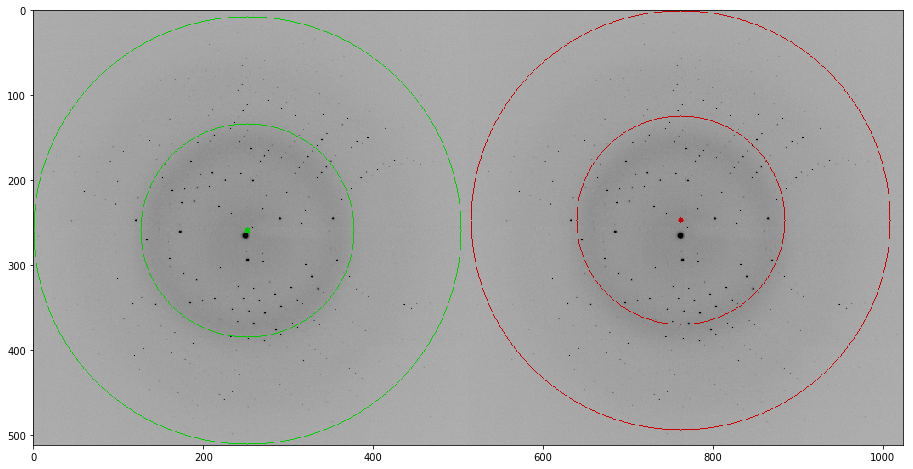

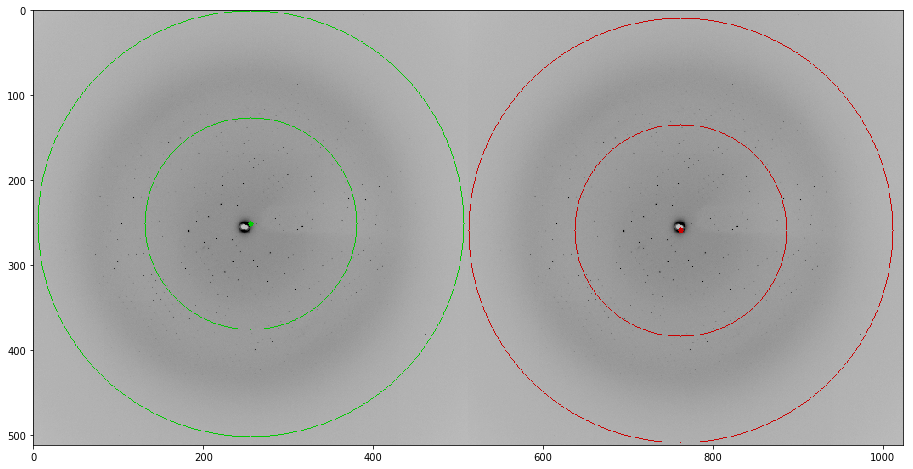

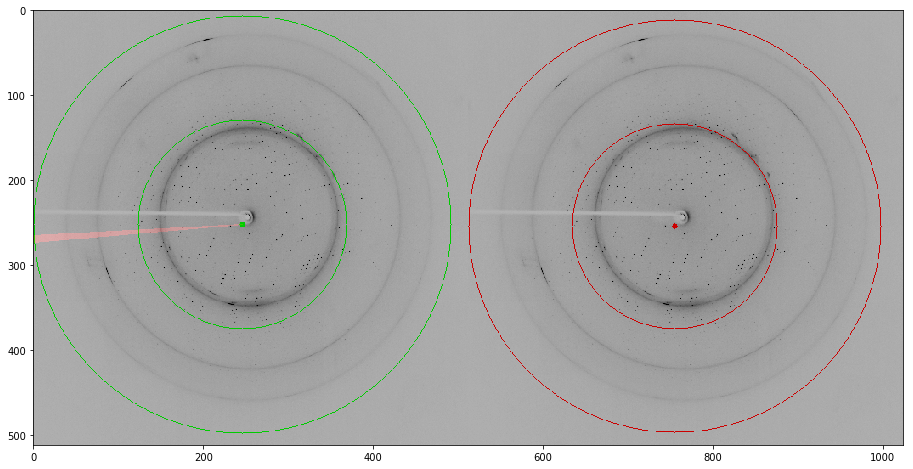

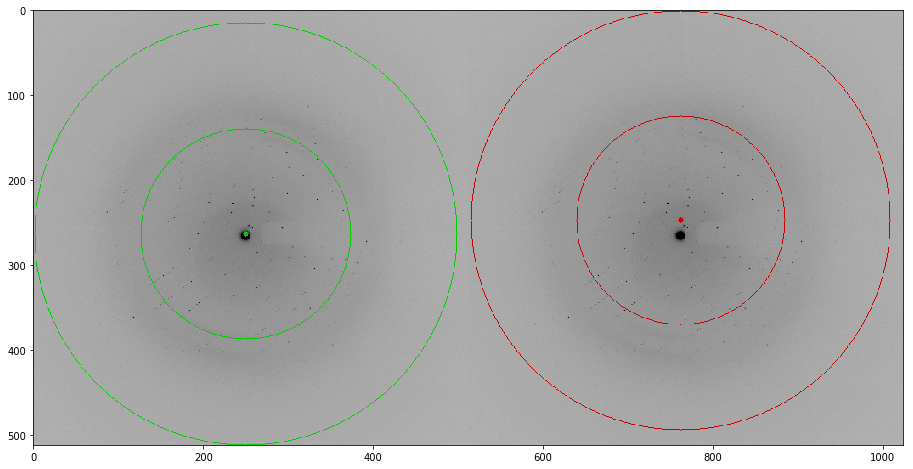

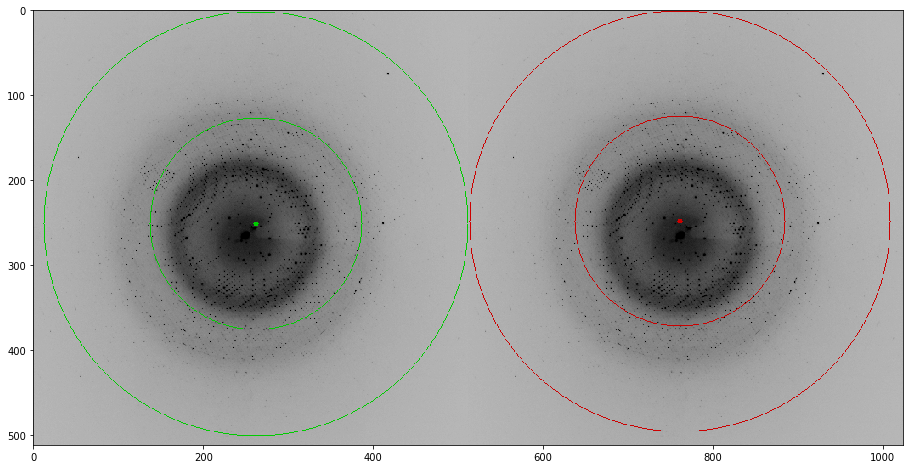

In [39]:
%matplotlib inline    


def visualize(img, center_x, center_y, mask_start=-1, mask_end=-1, center_color=(0, 0, 0)):
    center_x = int(center_x)
    center_y = int(center_y)

    radius = int(min(center_x, center_y, img.shape[0]-center_y, img.shape[1]-center_x))
    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    cv.circle(img, (center_x, center_y), 3, center_color, thickness=-1)
    cv.circle(img, (center_x, center_y), int(radius/2), center_color, thickness=1)
    cv.circle(img, (center_x, center_y), radius, center_color, thickness=1)

    ray_mask = make_ray_mask(img, (int(center_x), int(center_y)), mask_start, mask_end)
    return cv.addWeighted(ray_mask, 0.2, img, 0.8, 0)

      
def get_przemek_dict(json_path):
  import json
  with open(json_path) as json_data:
    d = json.load(json_data)
    return d
    

def numpy_shape_from_filename(filename):
  data = np.load(bz2.BZ2File(filename))
  return data.shape
    

def visualize_main():
  import matplotlib.pyplot as plt
  num_examples = 5
  
  df = pd.read_csv(f'{csv_dir}/centers.csv')
  metadata = pd.read_csv(f'{csv_dir}/metadata_centers.csv')
  df['image'] =  df['image'].map(lambda x: x[:-12])
  df.set_index('image', inplace=True)
  metadata.set_index('image', inplace=True)
  df = df.join(metadata, lsuffix='_ours', rsuffix='_przemka', how='inner')
  df = df.drop_duplicates()
  przemkowe = get_przemek_dict(f'{reflex_project_path}/przemkowe/pixel_sizes.json')

  i = 0
  for index, row in df.iterrows():
    if i >= num_examples:
      break
    i = i + 1  
    
    im_name_core = row.name
    img_filename = f'{images_dir}/{im_name_core}.512x512.png'
    np_filename = f'{raw_data_files}/{im_name_core}.npy.bz2'
    if not os.path.isfile(img_filename):
      raise FileNotFoundError("Invalid image filename: " + img_filename)
    if not os.path.isfile(np_filename):
      raise FileNotFoundError("Invalid numpy filename: " + np_filename)
    
    img = cv.imread(img_filename, cv.IMREAD_GRAYSCALE)
    
    our_img = visualize(img,
              row['x_ours'],
              row['y_ours'],
              row['mask_start'],
              row['mask_end'],
              center_color=(0,255,0)
             )
    
    width_coeff = przemkowe[im_name_core]['width']
    height_coeff = przemkowe[im_name_core]['height']
    metadata_x = row['x_przemka']
    metadata_y = row['y_przemka']
    wavelength = row['wavelength']
    distance = row['distance']
    np_shape = numpy_shape_from_filename(np_filename)
    
    converted_x = img.shape[1] * metadata_x / width_coeff / np_shape[1]
    converted_y = img.shape[0] * metadata_y / height_coeff / np_shape[0]
    
    #print(converted_x, converted_y)
    przemek_img = visualize(img,
              converted_x,
              converted_y,
              center_color=(255,0,0)
             )
    _, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(np.hstack((our_img, przemek_img)))

visualize_main()

## 3.5 Etap III. - Kompresowanie obrazu do wektora 1D

In [0]:
if os.path.exists(vectors_dir):
  
  # Plik ze srodkami
  centers_file = f'{csv_dir}/centers.csv'
  
  # Rozpoczynami pomiar czasu
  start = time.time()

  # Kompresja do wektorow z uzyciem Parallel
  main_external_call(images_dir, vectors_dir + '/', f'{csv_dir}/centers.csv', 8, 240)
    
  # Konczymy pomiar czasu
  end = time.time()
  time_str = time.strftime("%H:%M:%S", time.gmtime(end - start))
  
  print(f"\n --- KONIEC --- \n Przetworzono: {total} plikow, czas przetwarzania: {time_str} s")
  
else:
  raise FileNotFoundError("Katalog CSV nie istnieje!")